#Understanding nn.linear

In [ ]:
import torch
import torch.nn as nn

# Define a Linear layer
linear_layer = nn.Linear(in_features=3, out_features=2)

# Print the randomly initialized weights and bias
print("Weight matrix:\n", linear_layer.weight)
print("Bias:\n", linear_layer.bias)

# Define an input tensor (batch size of 1, with 3 features)
x = torch.tensor([[1.0, 2.0, 3.0]])  # Shape: (1, 3)

# Apply the linear transformation
output = linear_layer(x)

print("Output:\n", output)


Weight matrix:
 Parameter containing:
tensor([[-0.1075, -0.1473,  0.3572],
        [-0.0324,  0.1844, -0.2399]], requires_grad=True)
Bias:
 Parameter containing:
tensor([0.4683, 0.4867], requires_grad=True)
Output:
 tensor([[1.1379, 0.1033]], grad_fn=<AddmmBackward0>)


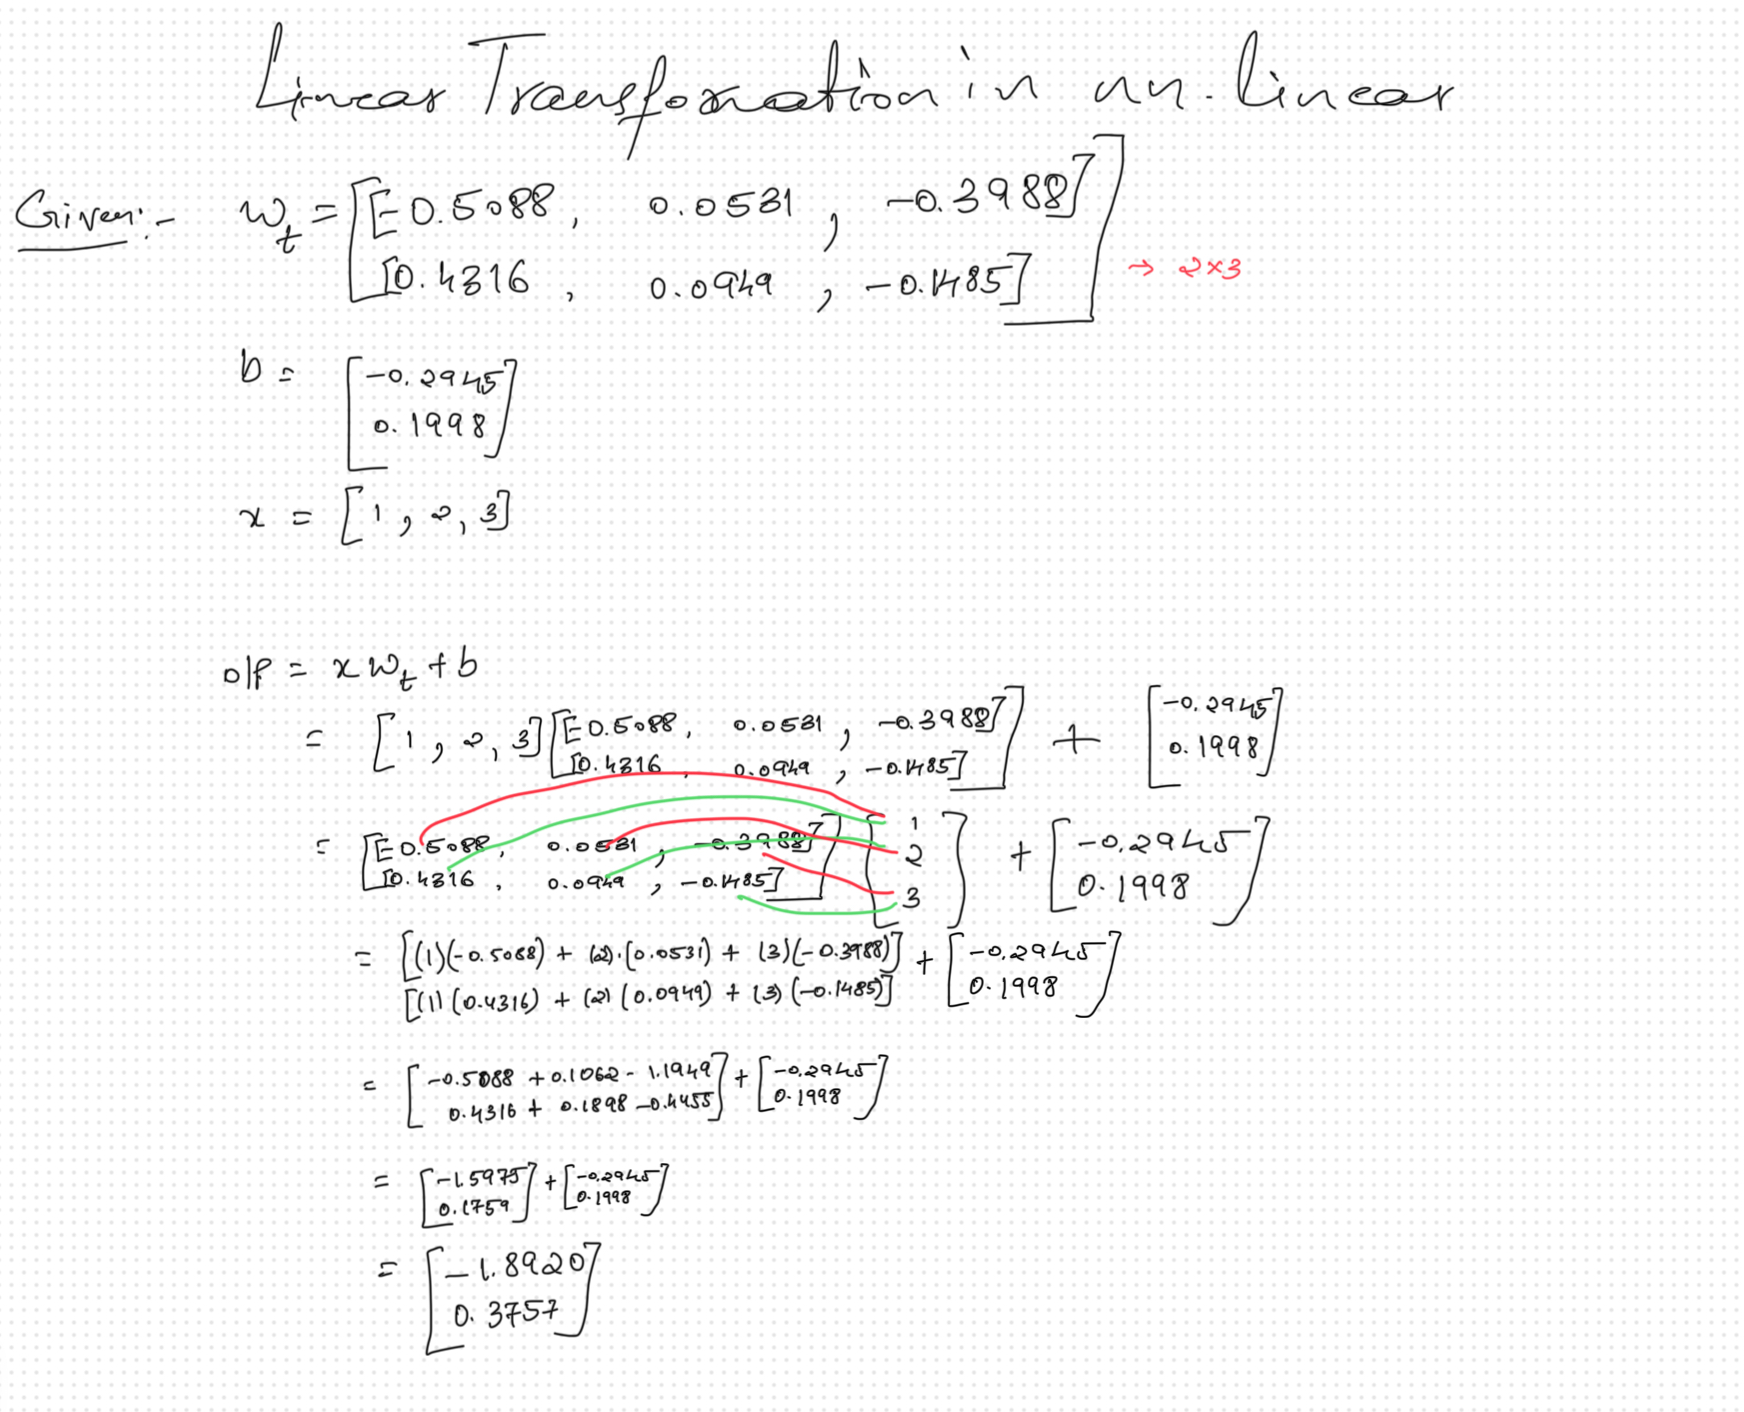

#Using pre-trined embedding function

In [ ]:
import torch
import torch.nn as nn

# Set a fixed seed for reproducibility
torch.manual_seed(42)

# Define the text and tokenize it (using a simple split)
text = ("I was excited to buy a new phone. At first, I loved using it. "
        "But after a few months, I started noticing issues. Now, I regret spending so much on it.")
words = text.split()

# Create a vocabulary mapping each unique word to an index
vocab = {word: idx for idx, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 8   # Size of each word embedding
hidden_size = 16    # Size of the LSTM hidden state

# Set the seed again before defining layers (ensures weights stay the same)
torch.manual_seed(42)

# Create an embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim)

# Define a custom LSTM cell to extract the internal gates and states
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Linear layers to compute gates from the input and previous hidden state
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, hidden):
        hx, cx = hidden
        # Compute the combined gate activations
        gates = self.x2h(x) + self.h2h(hx)
        # Split the activations into 4 parts corresponding to:
        # input gate, forget gate, candidate cell state, and output gate.
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        # Apply activation functions
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        # Compute the new cell state and hidden state
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)

        # Return the hidden state, cell state, all gate activations
        return hy, cy, forgetgate, ingate, cellgate, outgate

# Set the seed before creating model instance
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# Initialize hidden state and cell state (batch size is 1)
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# Process each word in the text
for word in words:
    # Convert word to index and then to an embedding vector
    idx = torch.tensor([vocab[word]])
    x = embedding(idx)

    # Pass the embedding and current states through the LSTM cell
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    # Extract relevant weights & biases for each gate
    W_f_x2h, W_i_x2h, W_c_x2h, W_o_x2h = lstm_cell.x2h.weight.chunk(4, 0)
    b_f_x2h, b_i_x2h, b_c_x2h, b_o_x2h = lstm_cell.x2h.bias.chunk(4, 0)

    W_f_h2h, W_i_h2h, W_c_h2h, W_o_h2h = lstm_cell.h2h.weight.chunk(4, 0)
    b_f_h2h, b_i_h2h, b_c_h2h, b_o_h2h = lstm_cell.h2h.bias.chunk(4, 0)

    # Print in required order
    print(f"\nWord: {word}")
    print("Word Embedding:", x.detach().numpy())

    # Forget Gate
    print("\n[Forget Gate]")
    print("Word Input Tensor:", x.detach().numpy())
    print("Forget Gate Weights (x2h):\n", W_f_x2h.detach().numpy())
    print("Previous Hidden State Tensor:\n", h.detach().numpy())
    print("Forget Gate Weights (h2h):\n", W_f_h2h.detach().numpy())
    print("Forget Gate Bias:\n", b_f_x2h.detach().numpy())
    print("Forget Gate Output:\n", f_gate.detach().numpy())

    # Input Gate
    print("\n[Input Gate]")
    print("Word Input Tensor:", x.detach().numpy())
    print("Input Gate Weights (x2h):\n", W_i_x2h.detach().numpy())
    print("Previous Hidden State Tensor:\n", h.detach().numpy())
    print("Input Gate Weights (h2h):\n", W_i_h2h.detach().numpy())
    print("Input Gate Bias:\n", b_i_x2h.detach().numpy())
    print("Input Gate Output:\n", i_gate.detach().numpy())

    # Cell State
    print("\n[Cell State]")
    print("Word Input Tensor:", x.detach().numpy())
    print("Cell State Weights (x2h):\n", W_c_x2h.detach().numpy())
    print("Previous Hidden State Tensor:\n", h.detach().numpy())
    print("Cell State Weights (h2h):\n", W_c_h2h.detach().numpy())
    print("Cell State Bias:\n", b_c_x2h.detach().numpy())
    print("Cell State Output:\n", c_gate.detach().numpy())

    # Updated Cell Memory and Hidden State
    print("\n[Updated States]")
    print("Updated Cell State (c_t):\n", c.detach().numpy())
    print("Updated Hidden State (h_t):\n", h.detach().numpy())

    print("-" * 100)


Streaming output truncated to the last 5000 lines.
 [-3.39360535e-02 -1.04040444e-01 -6.55363500e-02 -2.10557133e-01
  -1.98670864e-01  1.46322370e-01  2.13862360e-01  2.38575101e-01
  -1.80485576e-01  1.35215819e-01 -1.54741645e-01  1.49140060e-01
   1.80388570e-01  1.93467736e-01  1.80012822e-01  1.56393319e-01]
 [ 4.86591458e-03  1.14870608e-01 -8.94427299e-02  1.08858705e-01
  -8.03504884e-02 -4.19783592e-03 -2.17594713e-01 -6.53686523e-02
  -1.31468236e-01 -8.43302011e-02 -1.59646630e-01 -2.24861056e-01
   1.62791312e-02  1.62244797e-01  2.27687359e-01  1.45888537e-01]]
Input Gate Bias:
 [ 0.07601812  0.05161577  0.0967078  -0.17008281 -0.04523402  0.33591813
  0.23753466 -0.01328245 -0.33252788  0.01549546 -0.24076049  0.2875066
 -0.2146378  -0.02552712 -0.07846858  0.06291618]
Input Gate Output:
 [[0.41232225 0.6535235  0.34488276 0.531558   0.59588504 0.39025778
  0.32894778 0.8115453  0.6727188  0.50480384 0.6061911  0.6223785
  0.800449   0.30720252 0.7064407  0.6482136 ]]

[


Word: I
Word Embedding: [[-1.3846737  -0.87123615 -0.22336592  1.7173615   0.31888032 -0.42451897
   0.30572093 -0.7745925 ]]

[Forget Gate]
Word Input Tensor: [[-1.3846737  -0.87123615 -0.22336592  1.7173615   0.31888032 -0.42451897
   0.30572093 -0.7745925 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

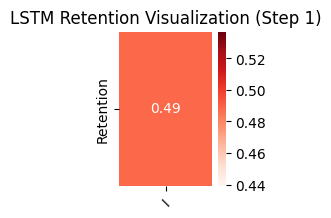


Word: was
Word Embedding: [[-0.9726739   0.95845777  1.6192005   1.4506098   0.26948154 -0.21037598
  -0.73280275  0.10429783]]

[Forget Gate]
Word Input Tensor: [[-0.9726739   0.95845777  1.6192005   1.4506098   0.26948154 -0.21037598
  -0.73280275  0.10429783]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [

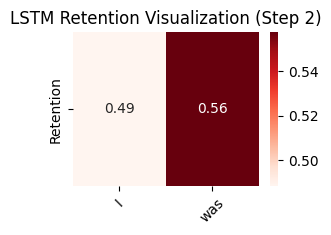


Word: excited
Word Embedding: [[-2.5095444   0.48800105  0.78458685  0.02864719  0.6407553   0.5832474
   1.0669267  -0.45015338]]

[Forget Gate]
Word Input Tensor: [[-2.5095444   0.48800105  0.78458685  0.02864719  0.6407553   0.5832474
   1.0669267  -0.45015338]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]


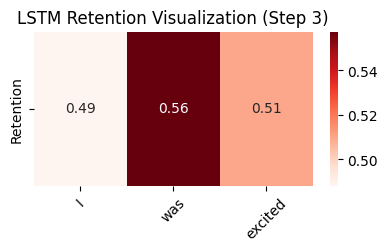


Word: to
Word Embedding: [[-1.4570291  -0.10233524 -0.59915304  0.4770564   0.7261772   0.09115186
  -0.3890652   0.5279165 ]]

[Forget Gate]
Word Input Tensor: [[-1.4570291  -0.10233524 -0.59915304  0.4770564   0.7261772   0.09115186
  -0.3890652   0.5279165 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 

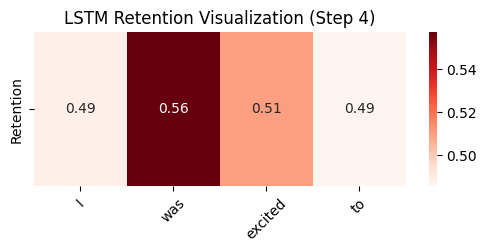


Word: buy
Word Embedding: [[ 1.4451338   0.85641253  2.2180758   0.5231655   0.34664667 -0.19733144
  -1.0545889   1.2779956 ]]

[Forget Gate]
Word Input Tensor: [[ 1.4451338   0.85641253  2.2180758   0.5231655   0.34664667 -0.19733144
  -1.0545889   1.2779956 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [

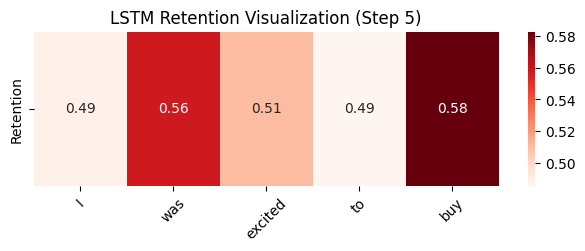


Word: a
Word Embedding: [[ 1.7743884  -0.921551    0.9624499  -0.33701515 -1.1753336   0.35805708
   0.4787679   1.3537    ]]

[Forget Gate]
Word Input Tensor: [[ 1.7743884  -0.921551    0.9624499  -0.33701515 -1.1753336   0.35805708
   0.4787679   1.3537    ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

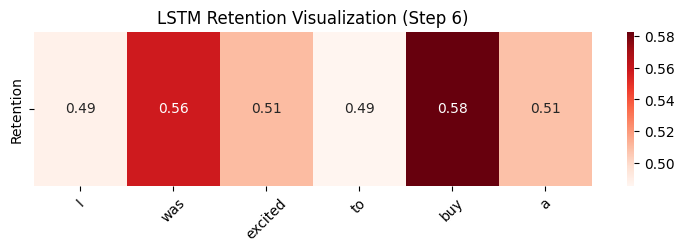


Word: new
Word Embedding: [[-0.7521353   1.648723   -0.39247864 -1.4036071  -0.7278813  -0.5594302
  -0.7688389   0.7624454 ]]

[Forget Gate]
Word Input Tensor: [[-0.7521353   1.648723   -0.39247864 -1.4036071  -0.7278813  -0.5594302
  -0.7688389   0.7624454 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

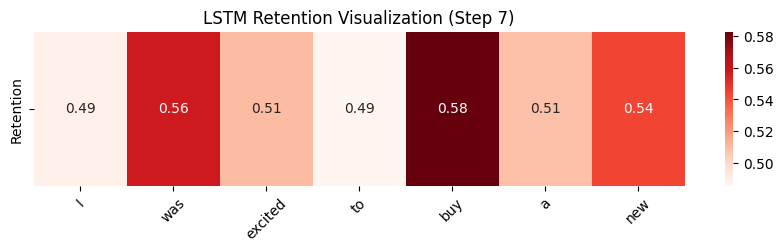


Word: phone.
Word Embedding: [[-1.5575725   0.9956361  -0.87978584 -0.60114205 -1.2741512   2.122785
  -1.2346531  -0.48791388]]

[Forget Gate]
Word Input Tensor: [[-1.5575725   0.9956361  -0.87978584 -0.60114205 -1.2741512   2.122785
  -1.2346531  -0.48791388]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 

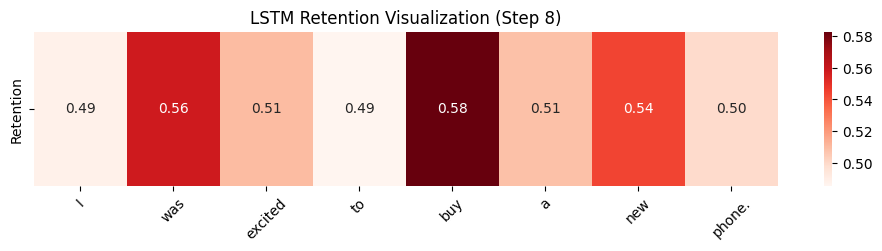


Word: At
Word Embedding: [[ 0.743952   -0.4815844  -1.0494661   0.6038988  -1.722295   -0.82776886
   1.334703    0.48353928]]

[Forget Gate]
Word Input Tensor: [[ 0.743952   -0.4815844  -1.0494661   0.6038988  -1.722295   -0.82776886
   1.334703    0.48353928]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 

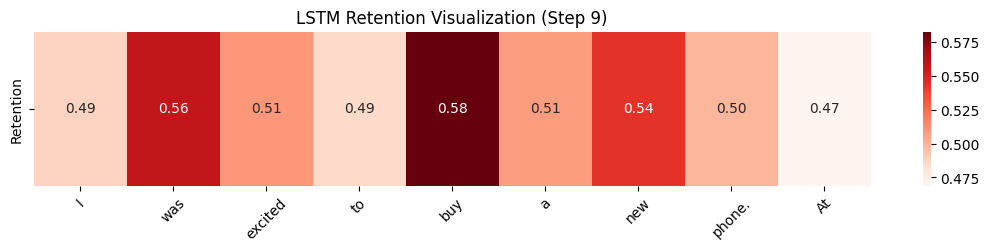


Word: first,
Word Embedding: [[-1.4032478   0.03600367 -0.06347727  0.6756149  -0.09780689  1.844594
  -1.1845374   1.3835493 ]]

[Forget Gate]
Word Input Tensor: [[-1.4032478   0.03600367 -0.06347727  0.6756149  -0.09780689  1.844594
  -1.1845374   1.3835493 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 

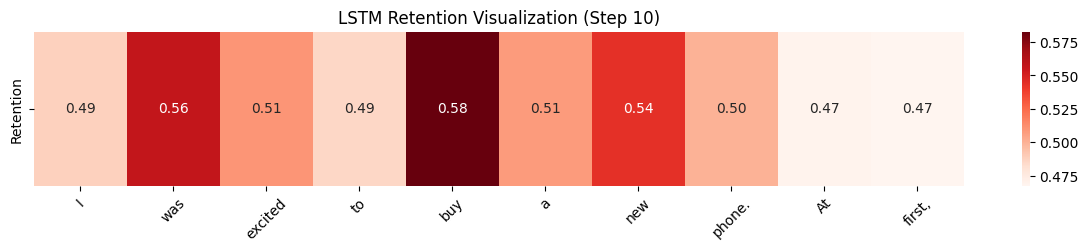


Word: I
Word Embedding: [[-1.3846737  -0.87123615 -0.22336592  1.7173615   0.31888032 -0.42451897
   0.30572093 -0.7745925 ]]

[Forget Gate]
Word Input Tensor: [[-1.3846737  -0.87123615 -0.22336592  1.7173615   0.31888032 -0.42451897
   0.30572093 -0.7745925 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

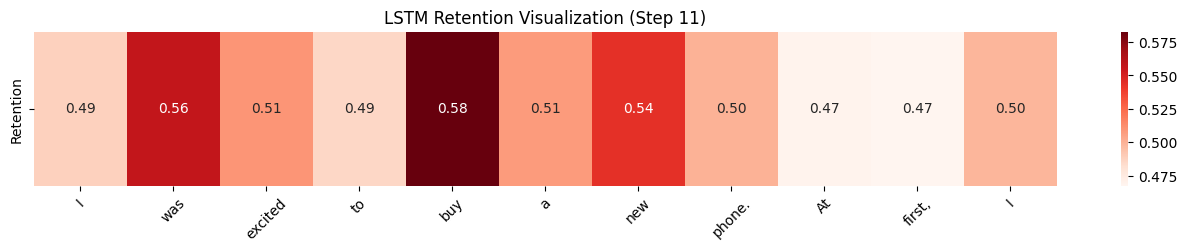


Word: loved
Word Embedding: [[ 1.141508    0.01856458 -1.8058051   0.9254349  -0.37534437  1.0330874
  -0.68665093  0.63681364]]

[Forget Gate]
Word Input Tensor: [[ 1.141508    0.01856458 -1.8058051   0.9254349  -0.37534437  1.0330874
  -0.68665093  0.63681364]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [

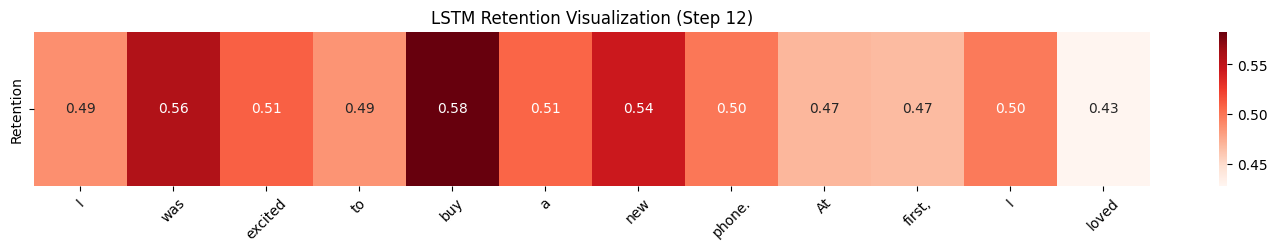


Word: using
Word Embedding: [[-0.18526748  0.75275886  0.4047578   0.17846599  0.2649095   1.2731683
  -0.00131086 -0.30360377]]

[Forget Gate]
Word Input Tensor: [[-0.18526748  0.75275886  0.4047578   0.17846599  0.2649095   1.2731683
  -0.00131086 -0.30360377]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [

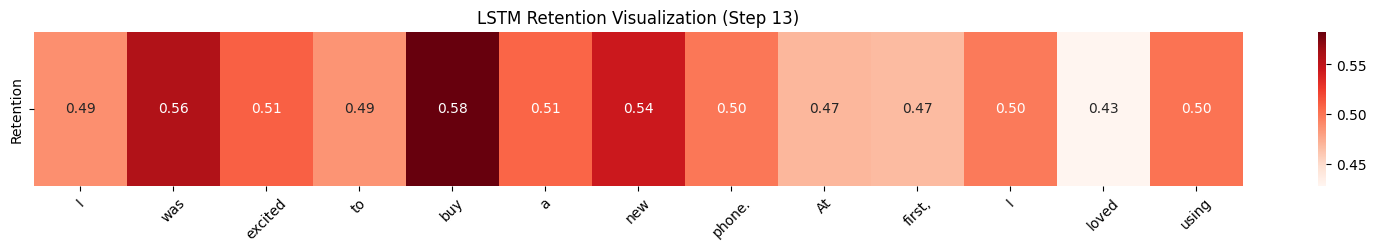


Word: it.
Word Embedding: [[-0.01268548  0.24083632  0.13253537  0.7642406   1.0950097   0.33989096
   0.7199675   0.41140762]]

[Forget Gate]
Word Input Tensor: [[-0.01268548  0.24083632  0.13253537  0.7642406   1.0950097   0.33989096
   0.7199675   0.41140762]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [

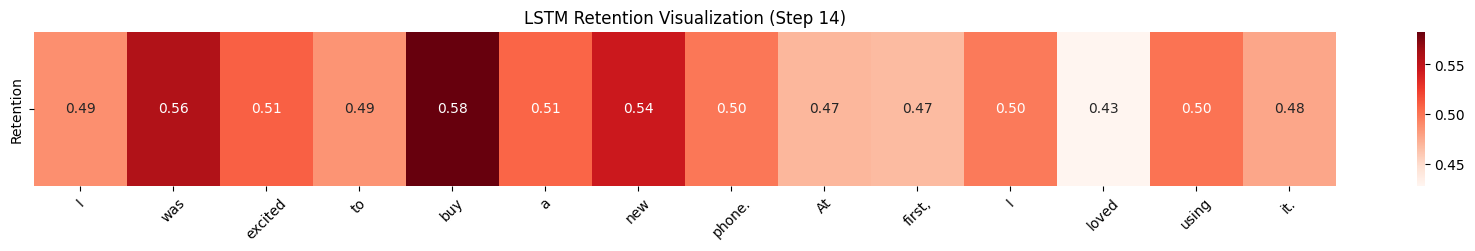


Word: But
Word Embedding: [[ 1.6423169  -0.15959747 -0.49739754  0.43958926 -0.75813115  1.0783176
   0.80080056  1.6806206 ]]

[Forget Gate]
Word Input Tensor: [[ 1.6423169  -0.15959747 -0.49739754  0.43958926 -0.75813115  1.0783176
   0.80080056  1.6806206 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

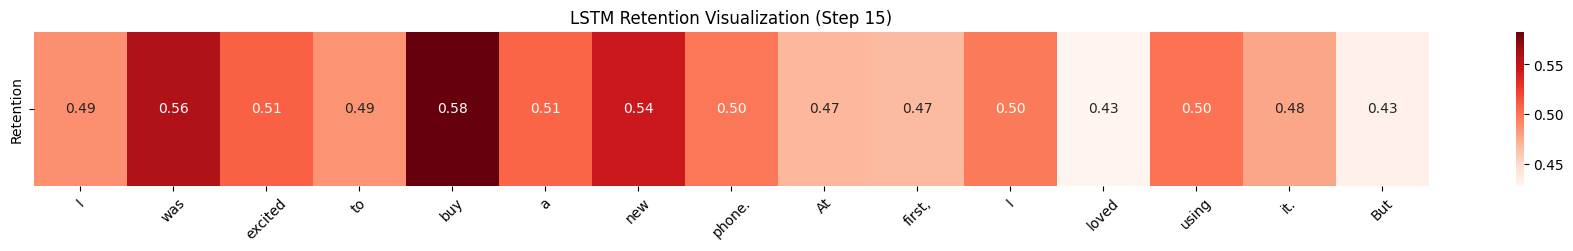


Word: after
Word Embedding: [[ 1.9269153   1.4872841   0.9007172  -2.105521    0.67841846 -1.2345449
  -0.04306748 -1.604667  ]]

[Forget Gate]
Word Input Tensor: [[ 1.9269153   1.4872841   0.9007172  -2.105521    0.67841846 -1.2345449
  -0.04306748 -1.604667  ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [

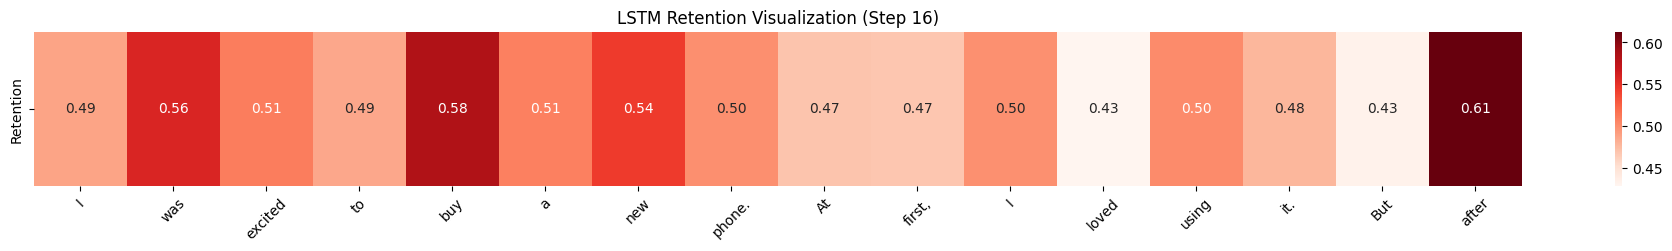


Word: a
Word Embedding: [[ 1.7743884  -0.921551    0.9624499  -0.33701515 -1.1753336   0.35805708
   0.4787679   1.3537    ]]

[Forget Gate]
Word Input Tensor: [[ 1.7743884  -0.921551    0.9624499  -0.33701515 -1.1753336   0.35805708
   0.4787679   1.3537    ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

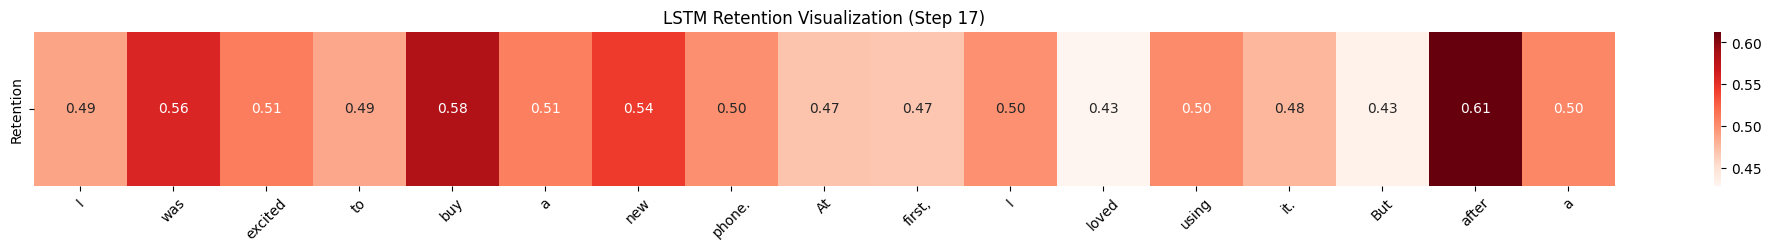


Word: few
Word Embedding: [[ 0.5260621   2.112038   -0.52075714 -0.9320061   0.18516134  1.0686918
   1.3065344   0.45983452]]

[Forget Gate]
Word Input Tensor: [[ 0.5260621   2.112038   -0.52075714 -0.9320061   0.18516134  1.0686918
   1.3065344   0.45983452]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

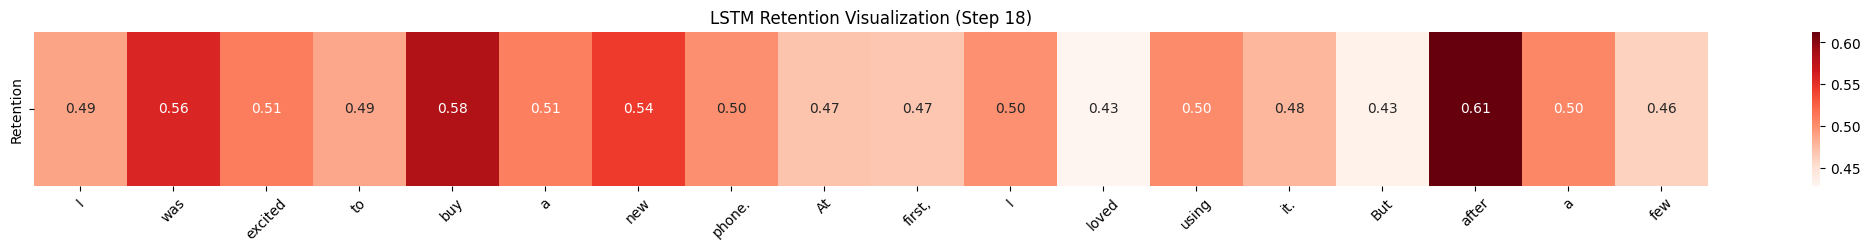


Word: months,
Word Embedding: [[-0.913823   -0.65813726  0.07802387  0.52580875 -0.48799172  1.191369
  -0.81400764 -0.7359928 ]]

[Forget Gate]
Word Input Tensor: [[-0.913823   -0.65813726  0.07802387  0.52580875 -0.48799172  1.191369
  -0.81400764 -0.7359928 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [

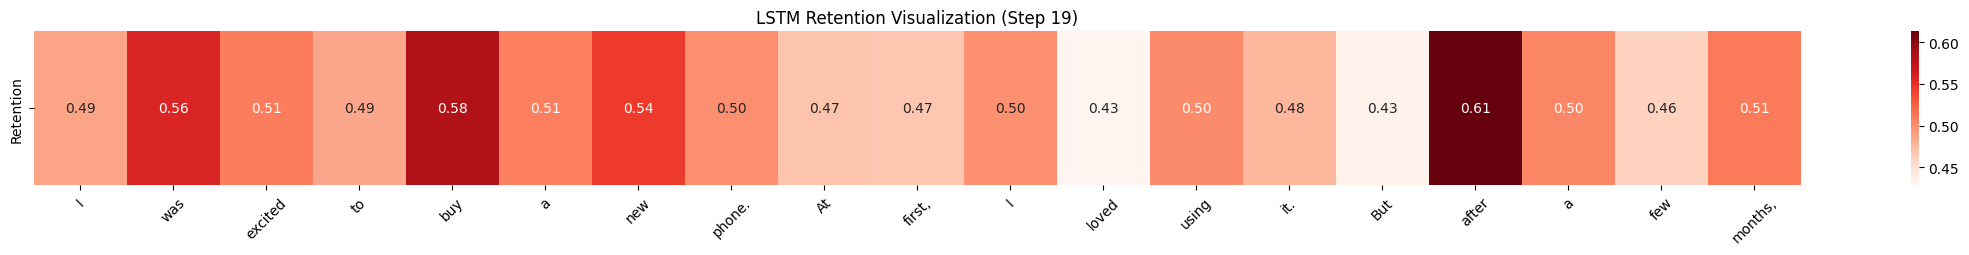


Word: I
Word Embedding: [[-1.3846737  -0.87123615 -0.22336592  1.7173615   0.31888032 -0.42451897
   0.30572093 -0.7745925 ]]

[Forget Gate]
Word Input Tensor: [[-1.3846737  -0.87123615 -0.22336592  1.7173615   0.31888032 -0.42451897
   0.30572093 -0.7745925 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

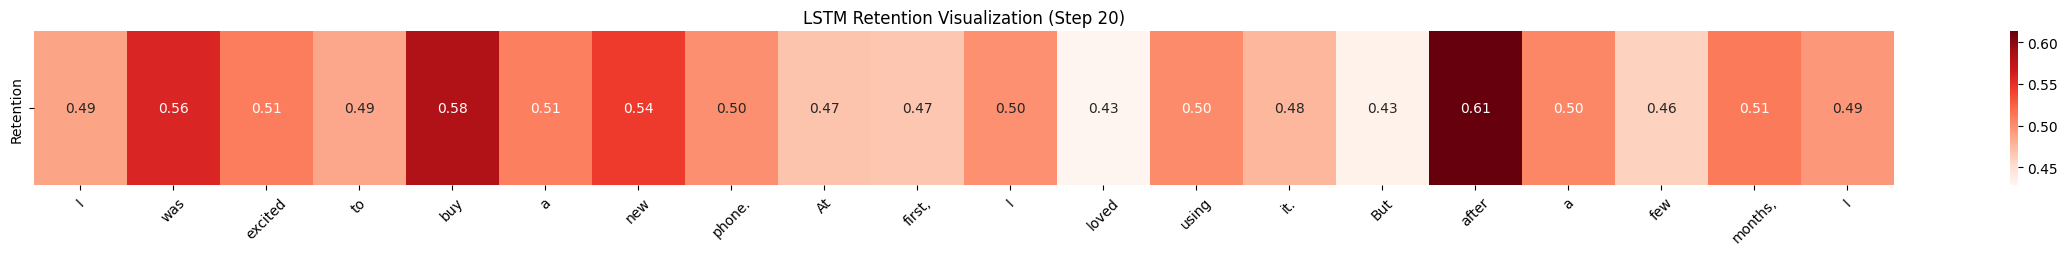


Word: started
Word Embedding: [[-0.5187733  -1.5012764  -1.9266542   0.12785123  1.0229133  -0.55579513
   0.70427275  0.709876  ]]

[Forget Gate]
Word Input Tensor: [[-0.5187733  -1.5012764  -1.9266542   0.12785123  1.0229133  -0.55579513
   0.70427275  0.709876  ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 

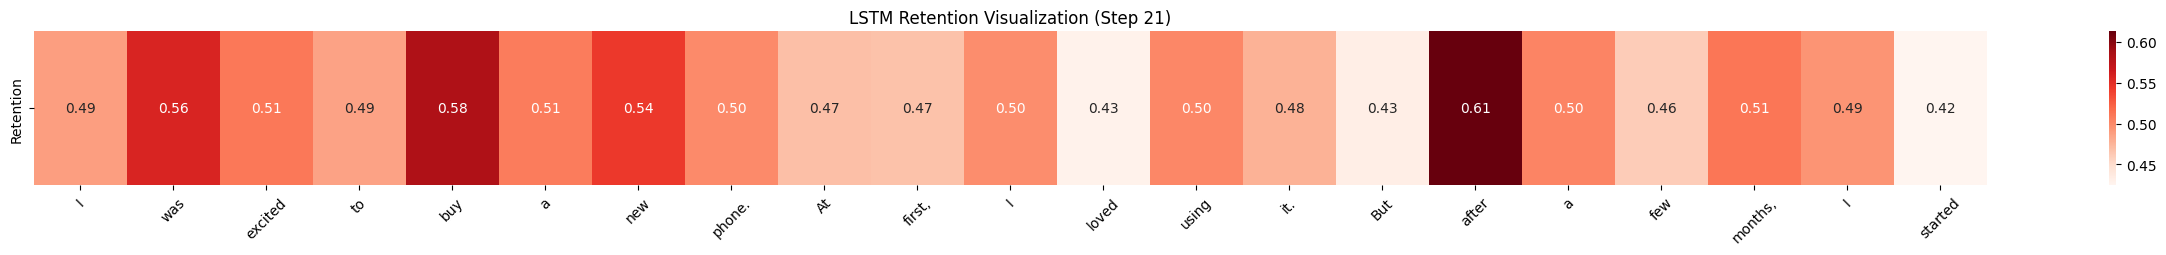


Word: noticing
Word Embedding: [[ 0.01086814 -0.33874235 -1.3406795  -0.58537054  0.5361881   0.5246226
   1.1412016   0.0516436 ]]

[Forget Gate]
Word Input Tensor: [[ 0.01086814 -0.33874235 -1.3406795  -0.58537054  0.5361881   0.5246226
   1.1412016   0.0516436 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]

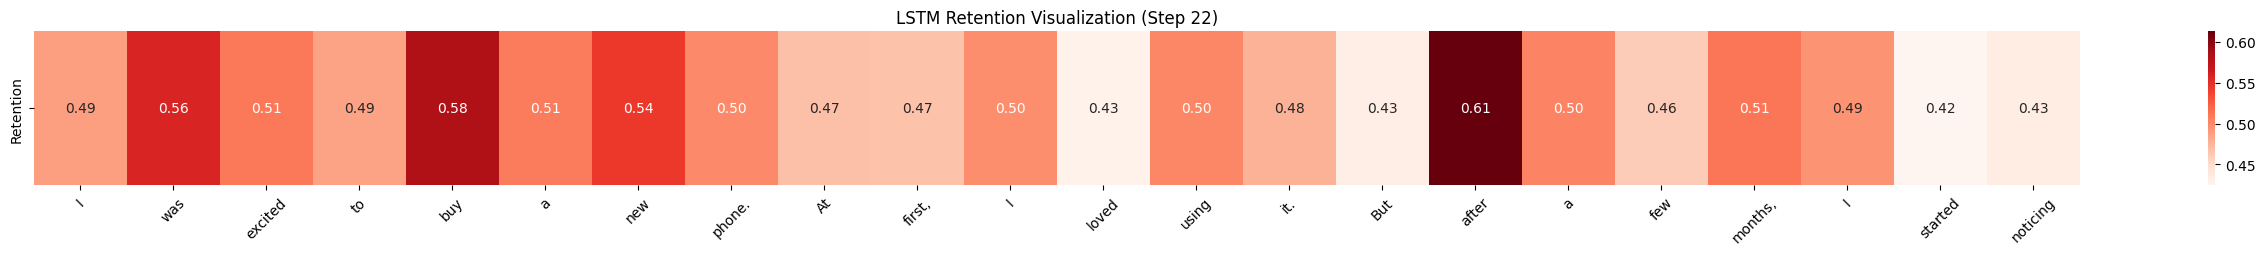


Word: issues.
Word Embedding: [[-1.9005532   0.22857653  0.0248594  -0.34595025  0.2868328  -0.7308424
   0.17482026 -1.0939293 ]]

[Forget Gate]
Word Input Tensor: [[-1.9005532   0.22857653  0.0248594  -0.34595025  0.2868328  -0.7308424
   0.17482026 -1.0939293 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]


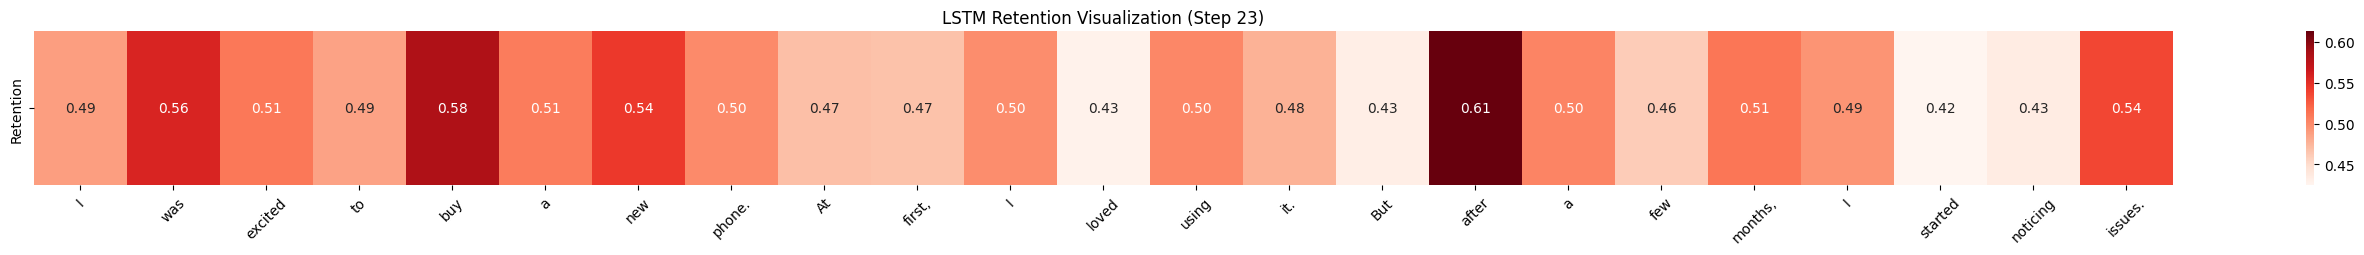


Word: Now,
Word Embedding: [[ 1.9311606   1.0118638  -1.4364065  -1.1298598  -0.13603453  1.6354096
   0.65474075  0.57600456]]

[Forget Gate]
Word Input Tensor: [[ 1.9311606   1.0118638  -1.4364065  -1.1298598  -0.13603453  1.6354096
   0.65474075  0.57600456]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 

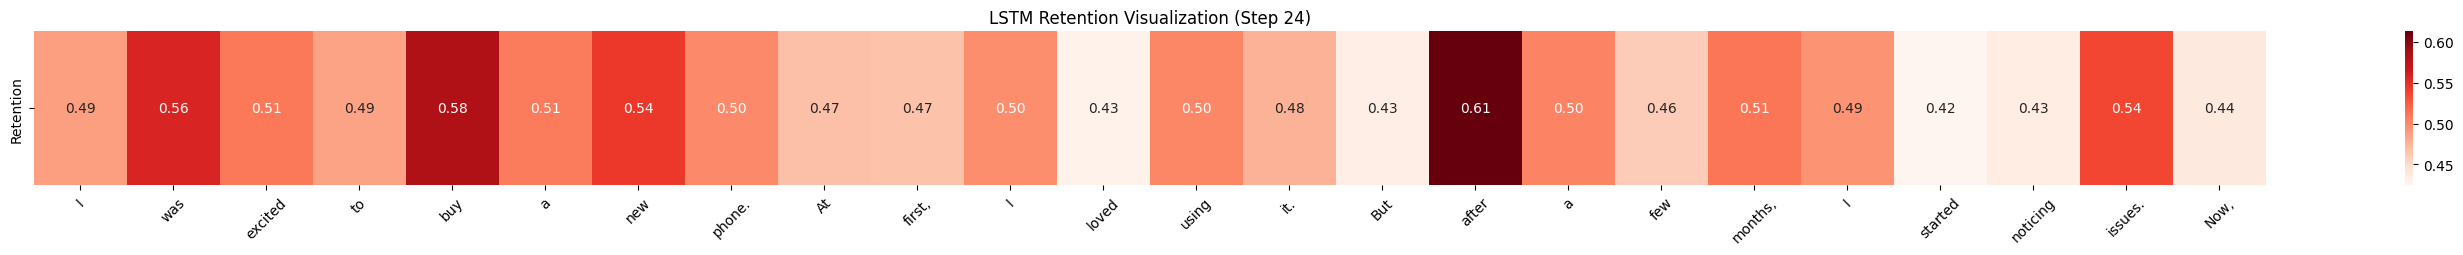


Word: I
Word Embedding: [[-1.3846737  -0.87123615 -0.22336592  1.7173615   0.31888032 -0.42451897
   0.30572093 -0.7745925 ]]

[Forget Gate]
Word Input Tensor: [[-1.3846737  -0.87123615 -0.22336592  1.7173615   0.31888032 -0.42451897
   0.30572093 -0.7745925 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0

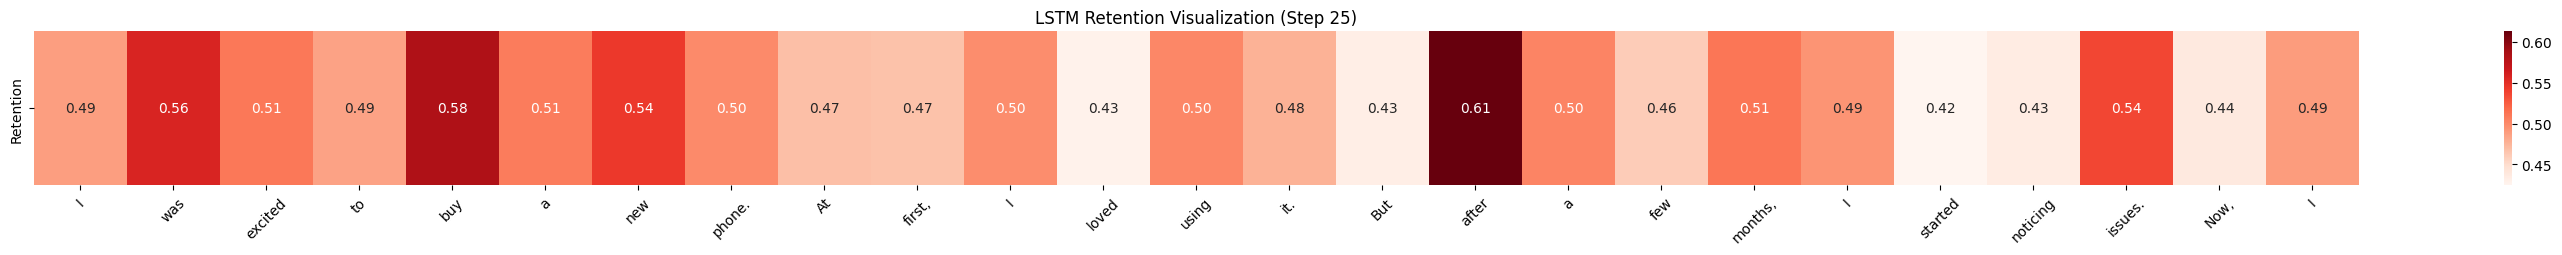


Word: regret
Word Embedding: [[ 0.3487517   0.96759415 -0.46568844  1.6047972  -2.4801202  -0.41754374
  -1.1954538   0.8123369 ]]

[Forget Gate]
Word Input Tensor: [[ 0.3487517   0.96759415 -0.46568844  1.6047972  -2.4801202  -0.41754374
  -1.1954538   0.8123369 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]

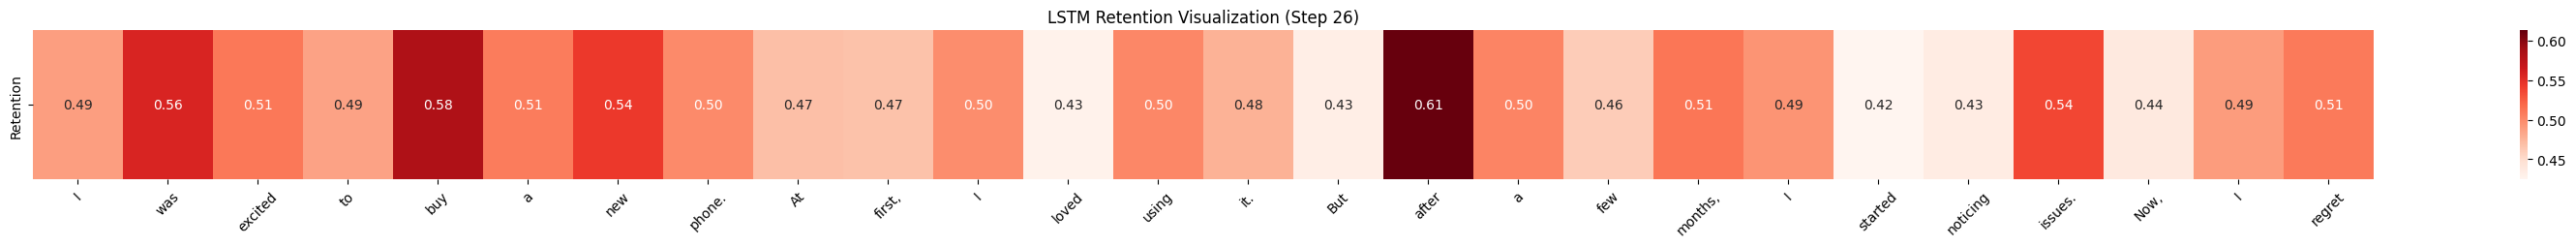


Word: spending
Word Embedding: [[-1.6021603   1.3528969   1.2888277   0.05229547 -1.5468504   0.75670606
   0.7755195   2.0265355 ]]

[Forget Gate]
Word Input Tensor: [[-1.6021603   1.3528969   1.2888277   0.05229547 -1.5468504   0.75670606
   0.7755195   2.0265355 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466

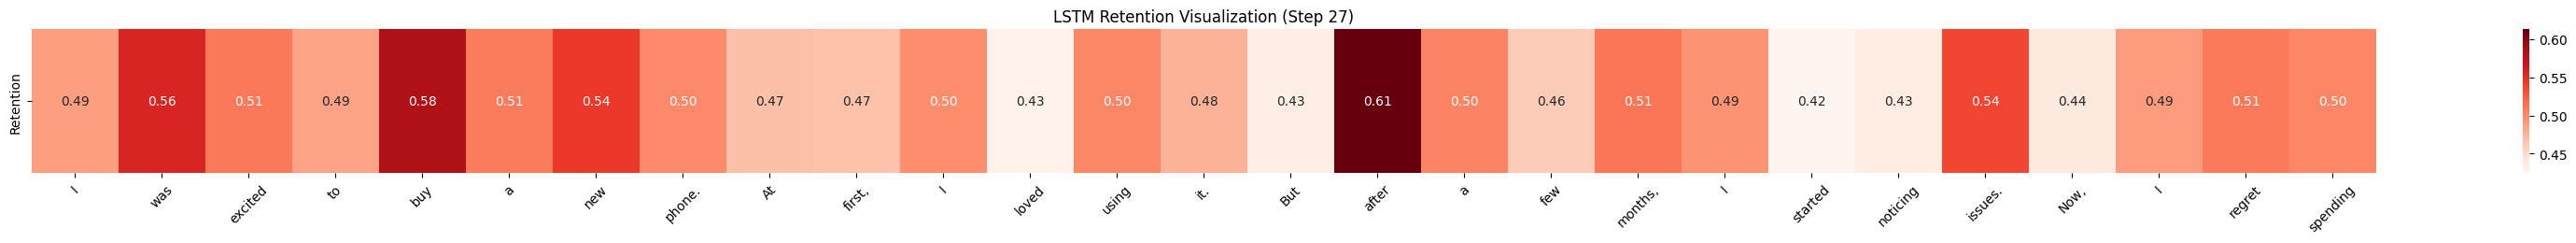


Word: so
Word Embedding: [[-0.17219013  0.52378845  0.05662182  0.42629614  0.57500505 -0.6417241
  -2.2063985  -0.75080305]]

[Forget Gate]
Word Input Tensor: [[-0.17219013  0.52378845  0.05662182  0.42629614  0.57500505 -0.6417241
  -2.2063985  -0.75080305]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 0.

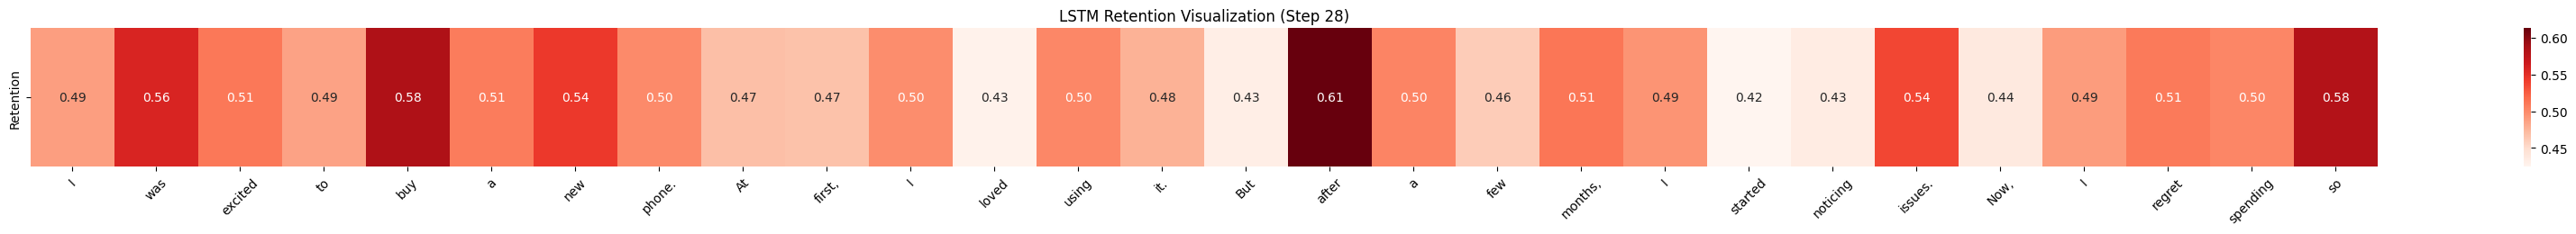


Word: much
Word Embedding: [[ 0.03581761  0.12058873 -0.8056637  -0.20757683 -0.9319478  -1.5909662
  -1.1359757  -0.5225976 ]]

[Forget Gate]
Word Input Tensor: [[ 0.03581761  0.12058873 -0.8056637  -0.20757683 -0.9319478  -1.5909662
  -1.1359757  -0.5225976 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 

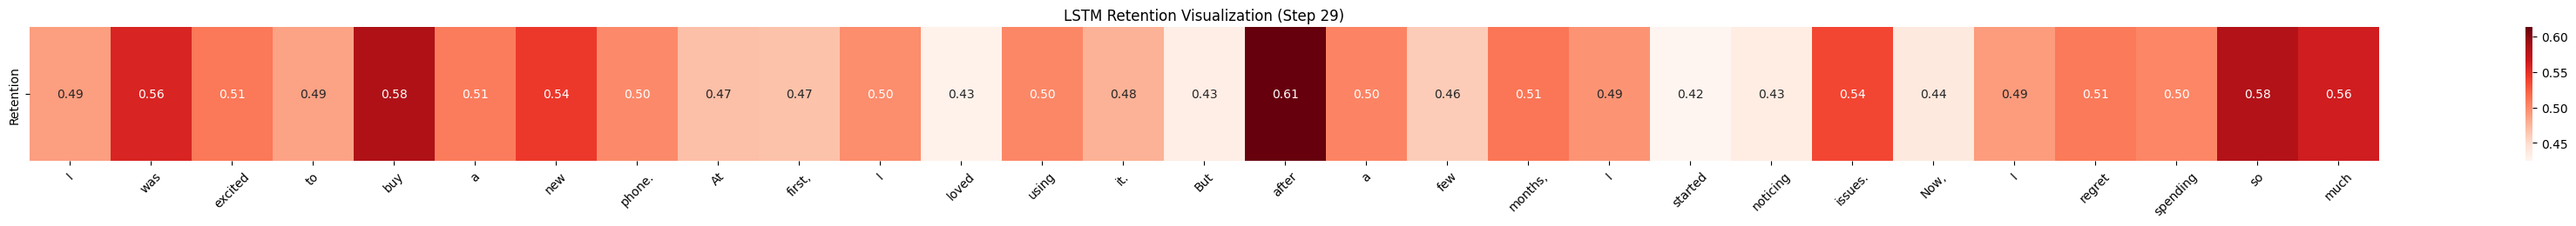


Word: on
Word Embedding: [[ 1.2791244   1.2964228   0.6104665   1.3347378  -0.23162432  0.04175949
  -0.2515753   0.8598585 ]]

[Forget Gate]
Word Input Tensor: [[ 1.2791244   1.2964228   0.6104665   1.3347378  -0.23162432  0.04175949
  -0.2515753   0.8598585 ]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [ 

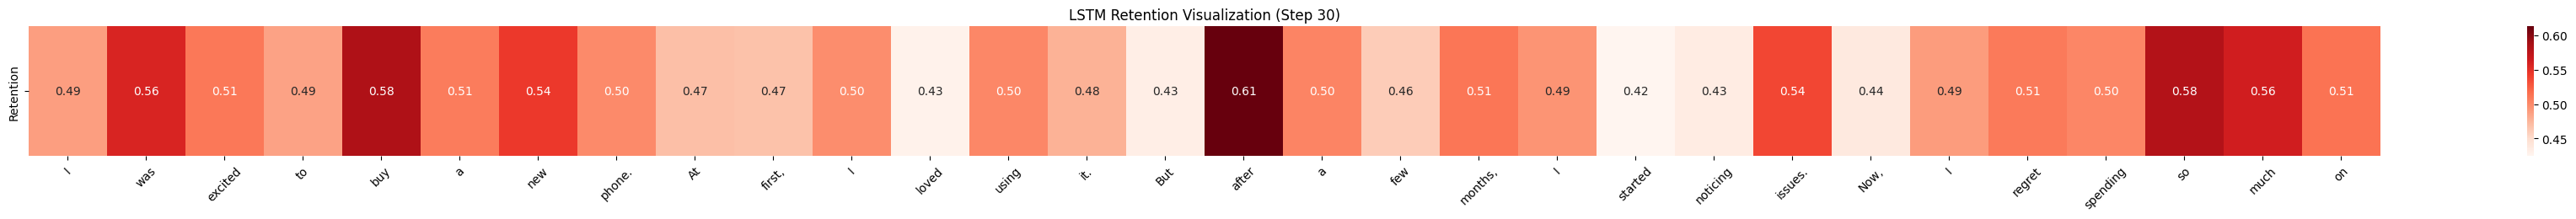


Word: it.
Word Embedding: [[-0.01268548  0.24083632  0.13253537  0.7642406   1.0950097   0.33989096
   0.7199675   0.41140762]]

[Forget Gate]
Word Input Tensor: [[-0.01268548  0.24083632  0.13253537  0.7642406   1.0950097   0.33989096
   0.7199675   0.41140762]]
Forget Gate Weights (x2h):
 [[ 0.2703052   0.2934521  -0.08282783  0.32477814 -0.07746481  0.07134378
  -0.17212924  0.20763578]
 [ 0.31167248 -0.2593767   0.30730724  0.0661708   0.2612084   0.04788194
   0.17047924 -0.04991856]
 [ 0.2725493   0.05225834 -0.16505283  0.09012016 -0.162895   -0.04146221
  -0.14359865  0.23453705]
 [-0.2790845  -0.16299176 -0.09983455 -0.21258192  0.03336947 -0.3491973
   0.31929728 -0.30033237]
 [ 0.27295288  0.05883805 -0.11480039  0.2184783   0.05510157  0.28565818
   0.03865035 -0.11150125]
 [ 0.09499402 -0.09587641  0.1487956   0.3156603   0.20437491 -0.15456383
   0.20409387  0.06325997]
 [ 0.17954679 -0.21549258 -0.34998548 -0.13659908 -0.27118352  0.2901043
   0.10183445  0.1464466 ]
 [

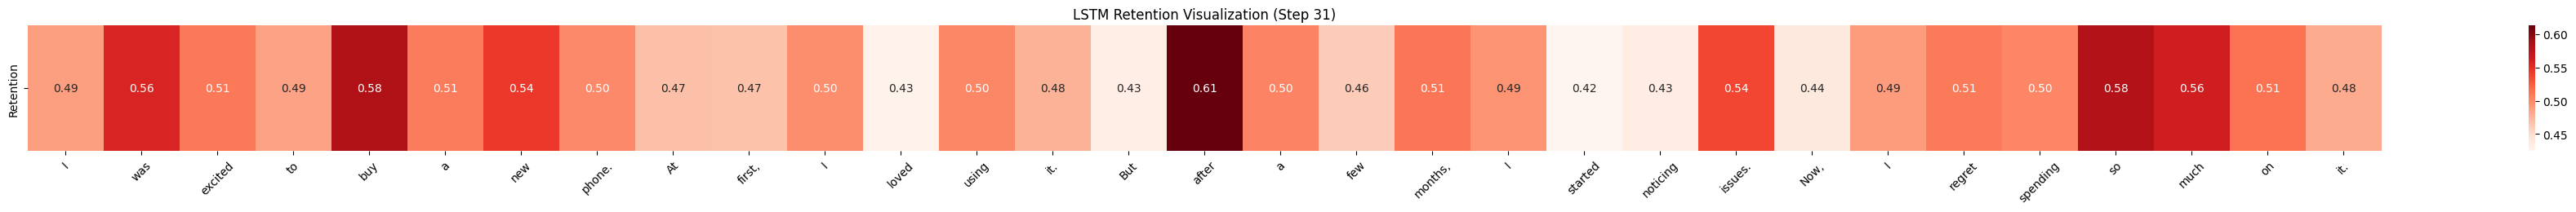

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Set a fixed seed for reproducibility
torch.manual_seed(42)

# Define the text and tokenize it (using a simple split)
text = ("I was excited to buy a new phone. At first, I loved using it. "
        "But after a few months, I started noticing issues. Now, I regret spending so much on it.")
words = text.split()

# Create a vocabulary mapping each unique word to an index
vocab = {word: idx for idx, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 8   # Size of each word embedding
hidden_size = 16    # Size of the LSTM hidden state

# Set the seed again before defining layers (ensures weights stay the same)
torch.manual_seed(42)

# Create an embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim)

# Define a custom LSTM cell to extract the internal gates and states
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Linear layers to compute gates from the input and previous hidden state
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, hidden):
        hx, cx = hidden
        # Compute the combined gate activations
        gates = self.x2h(x) + self.h2h(hx)
        # Split the activations into 4 parts:
        # input gate, forget gate, candidate cell state, and output gate.
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        # Apply activation functions
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        # Compute the new cell state and hidden state
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)

        # Return hidden state, cell state, and each gate
        return hy, cy, forgetgate, ingate, cellgate, outgate

# Instantiate the custom LSTM cell
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# Initialize hidden state and cell state (batch size is 1)
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# Store words and forget gate retention for visualization
words_list = []
forget_retention = []

# Process each word in the text
for step, word in enumerate(words):
    # Convert word to index and then to an embedding vector
    idx = torch.tensor([vocab[word]])
    x = embedding(idx)

    # Pass the embedding and current states through the LSTM cell
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    # Extract relevant weights & biases for each gate
    W_f_x2h, W_i_x2h, W_c_x2h, W_o_x2h = lstm_cell.x2h.weight.chunk(4, 0)
    b_f_x2h, b_i_x2h, b_c_x2h, b_o_x2h = lstm_cell.x2h.bias.chunk(4, 0)

    W_f_h2h, W_i_h2h, W_c_h2h, W_o_h2h = lstm_cell.h2h.weight.chunk(4, 0)
    b_f_h2h, b_i_h2h, b_c_h2h, b_o_h2h = lstm_cell.h2h.bias.chunk(4, 0)

    # Print in required order
    print(f"\nWord: {word}")
    print("Word Embedding:", x.detach().numpy())

    # Forget Gate
    print("\n[Forget Gate]")
    print("Word Input Tensor:", x.detach().numpy())
    print("Forget Gate Weights (x2h):\n", W_f_x2h.detach().numpy())
    print("Previous Hidden State Tensor:\n", h.detach().numpy())
    print("Forget Gate Weights (h2h):\n", W_f_h2h.detach().numpy())
    print("Forget Gate Bias:\n", b_f_x2h.detach().numpy())
    print("Forget Gate Output:\n", f_gate.detach().numpy())

    # Input Gate
    print("\n[Input Gate]")
    print("Word Input Tensor:", x.detach().numpy())
    print("Input Gate Weights (x2h):\n", W_i_x2h.detach().numpy())
    print("Previous Hidden State Tensor:\n", h.detach().numpy())
    print("Input Gate Weights (h2h):\n", W_i_h2h.detach().numpy())
    print("Input Gate Bias:\n", b_i_x2h.detach().numpy())
    print("Input Gate Output:\n", i_gate.detach().numpy())

    # Cell State
    print("\n[Cell State]")
    print("Word Input Tensor:", x.detach().numpy())
    print("Cell State Weights (x2h):\n", W_c_x2h.detach().numpy())
    print("Previous Hidden State Tensor:\n", h.detach().numpy())
    print("Cell State Weights (h2h):\n", W_c_h2h.detach().numpy())
    print("Cell State Bias:\n", b_c_x2h.detach().numpy())
    print("Cell State Output:\n", c_gate.detach().numpy())

    # Updated Cell Memory and Hidden State
    print("\n[Updated States]")
    print("Updated Cell State (c_t):\n", c.detach().numpy())
    print("Updated Hidden State (h_t):\n", h.detach().numpy())

    print("-" * 100)

    # ---- Progressive Heatmap ----
    # Compute mean forget gate value (representing retention)
    forget_mean = f_gate.mean().item()

    # Store word and forget retention
    words_list.append(word)
    forget_retention.append(forget_mean)

    # Generate heatmap with all words processed so far
    plt.figure(figsize=(len(words_list) * 1.5, 2))  # Dynamic width based on words processed
    sns.heatmap([forget_retention], annot=True, fmt=".2f", cmap="Reds",
                xticklabels=words_list, yticklabels=["Retention"])
    plt.xticks(rotation=45)
    plt.title(f"LSTM Retention Visualization (Step {step+1})")
    plt.show()


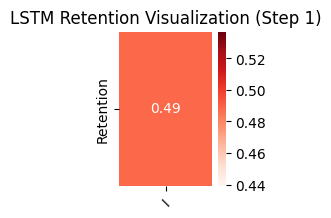

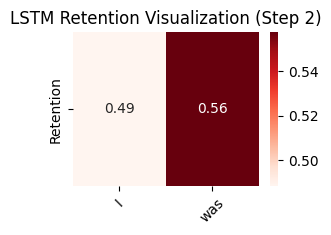

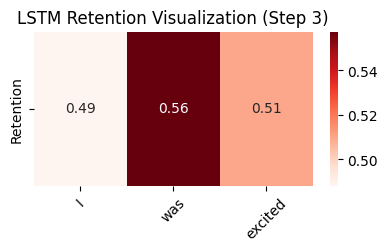

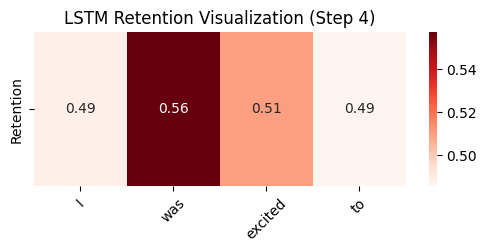

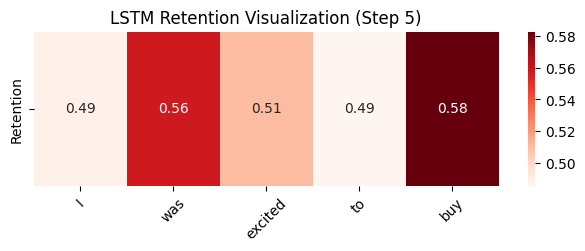

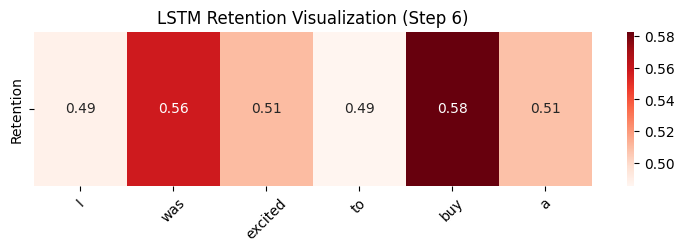

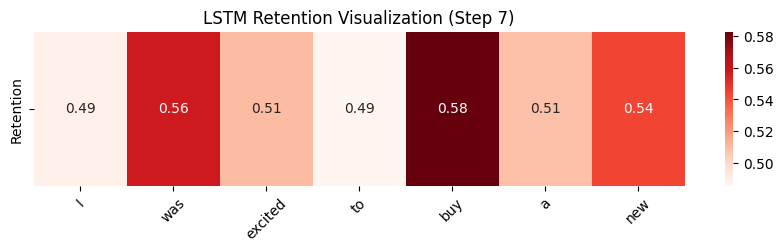

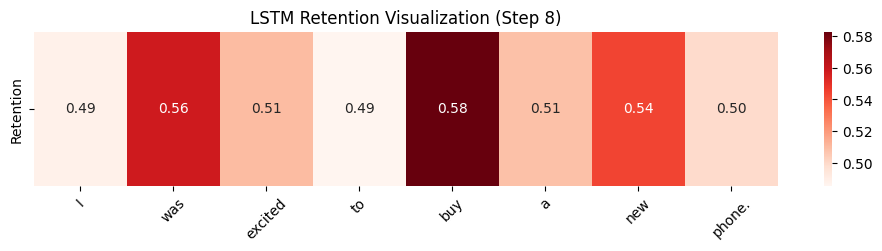

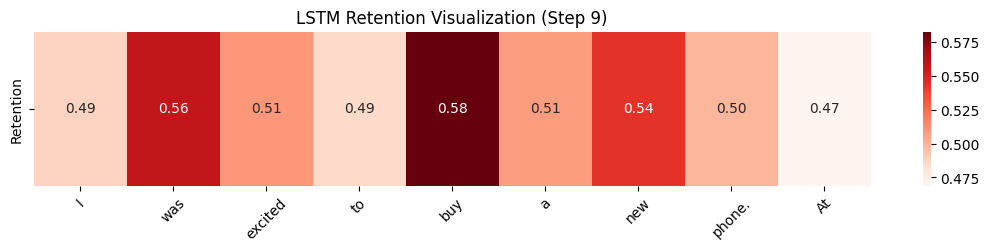

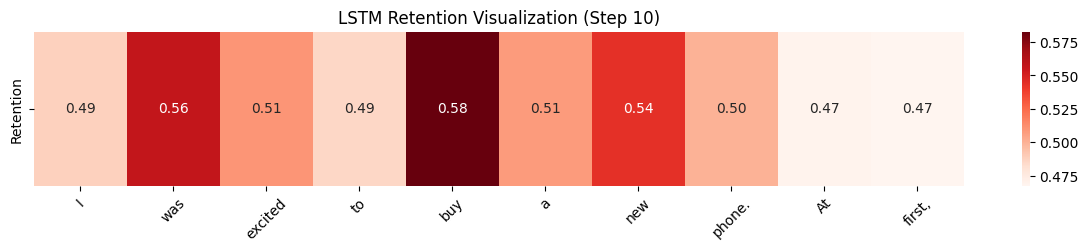

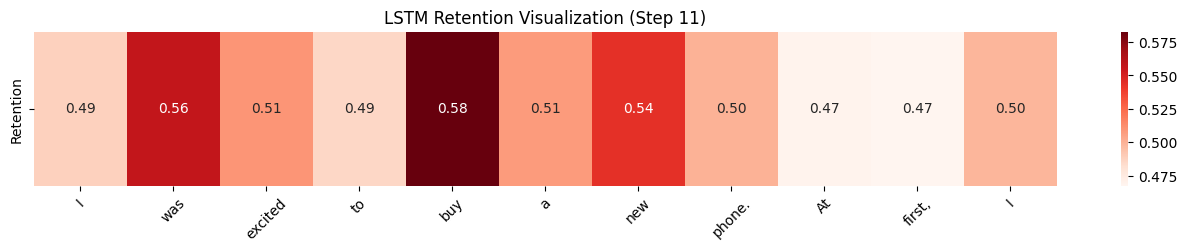

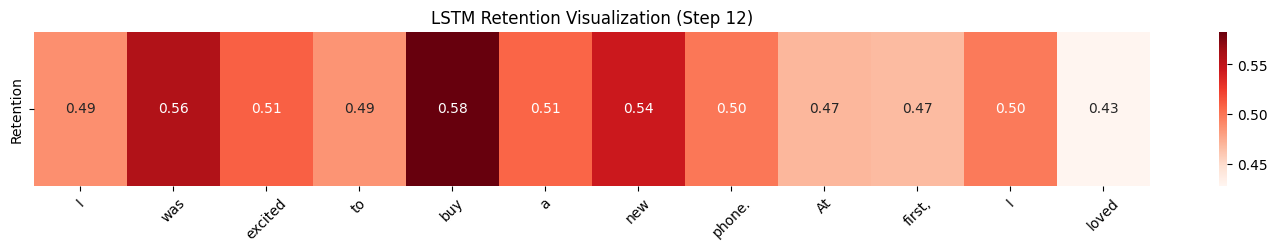

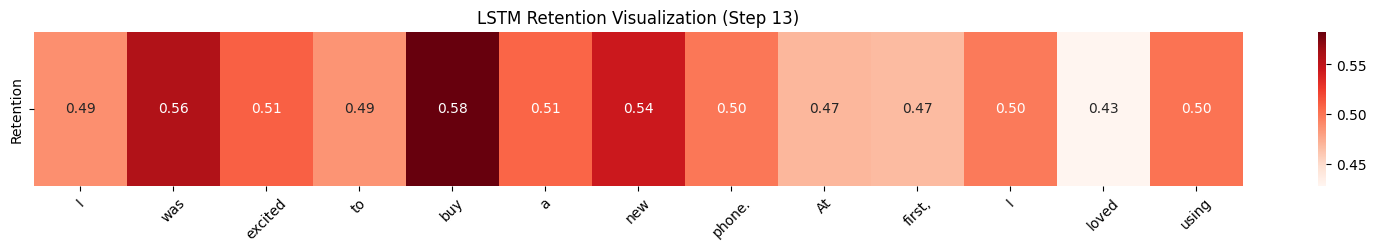

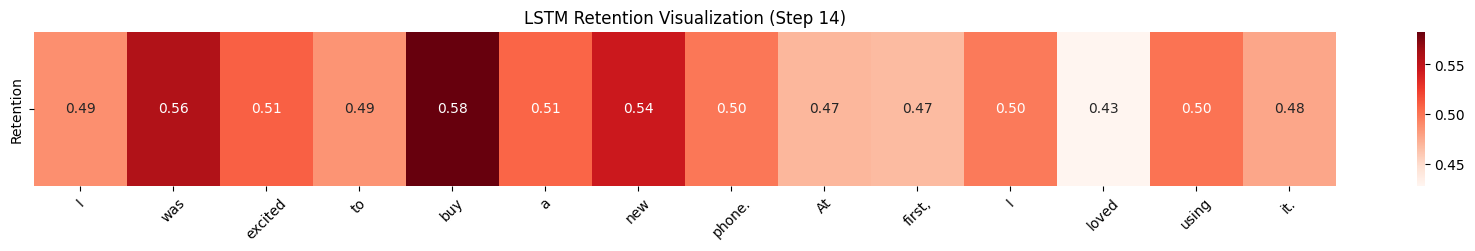

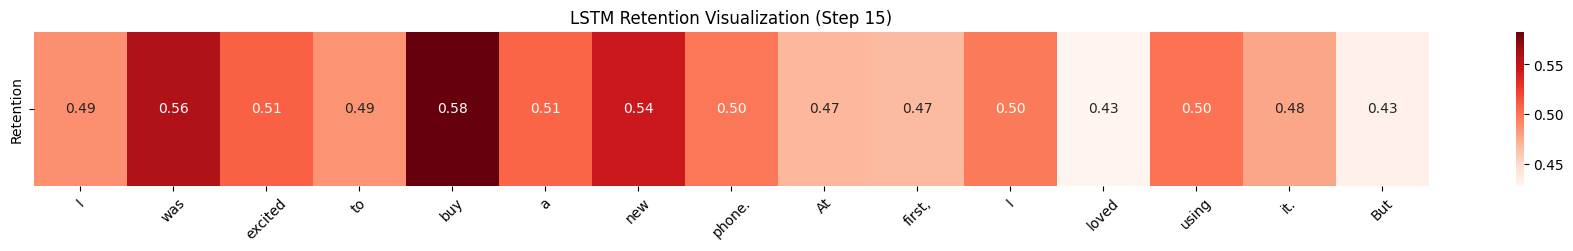

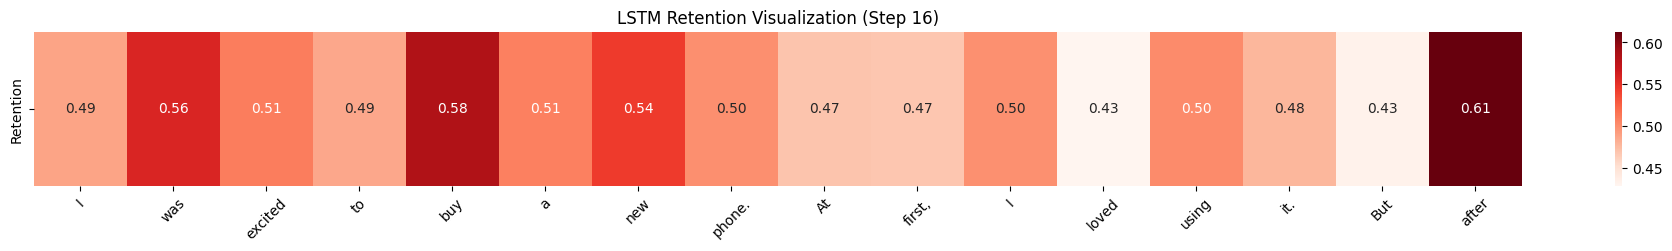

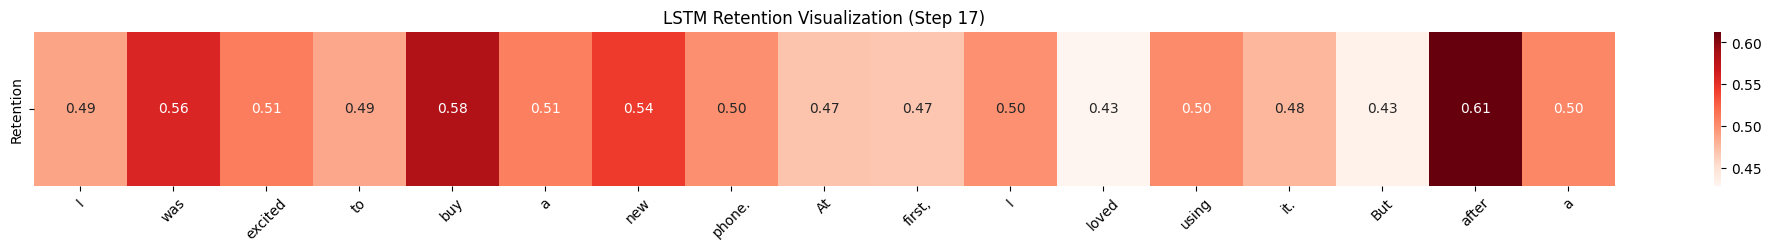

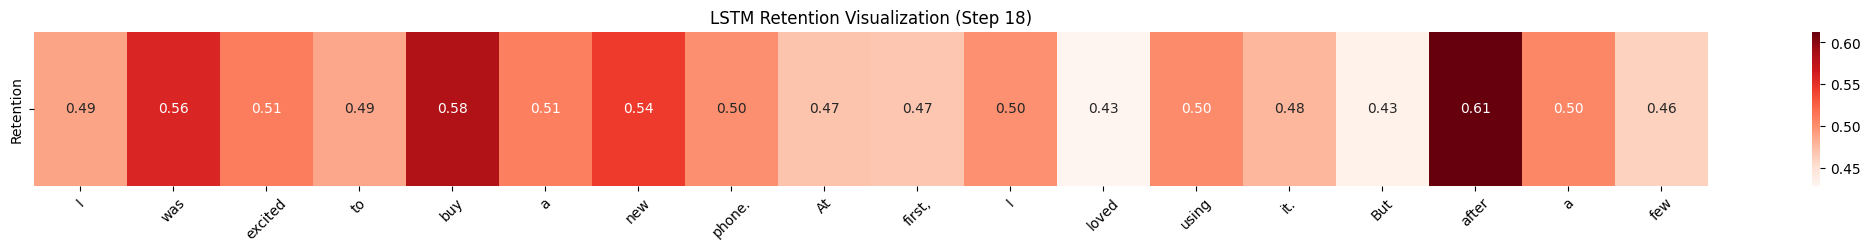

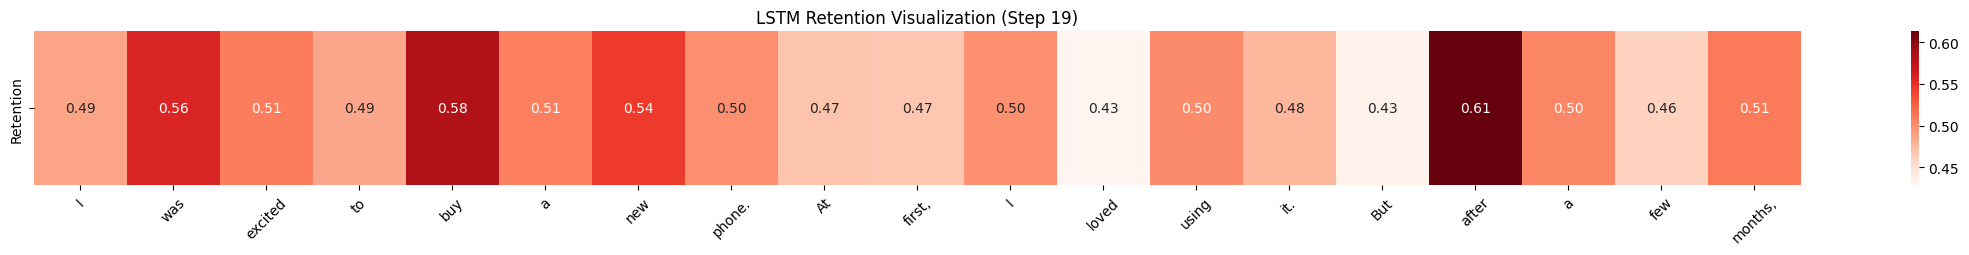

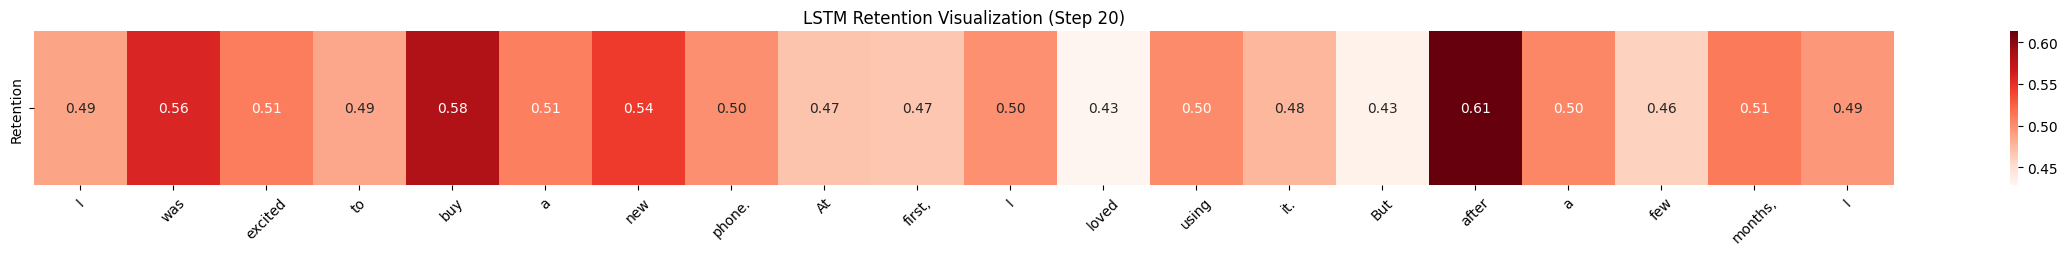

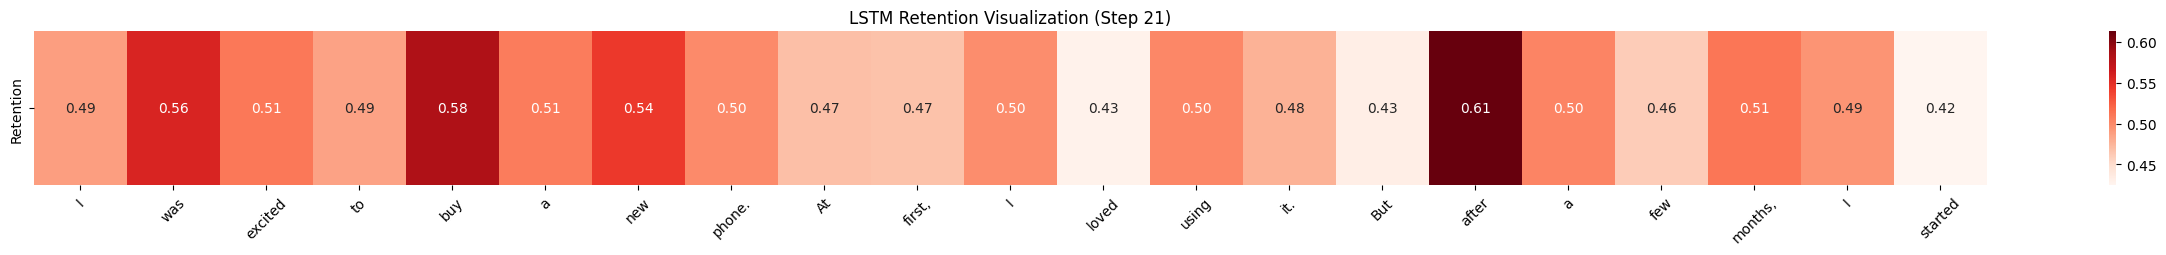

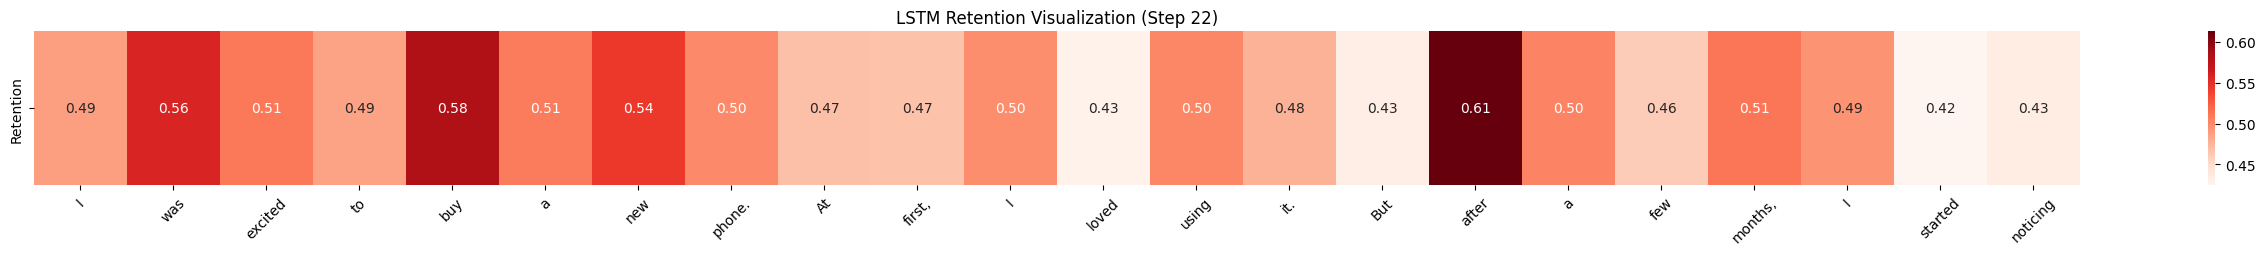

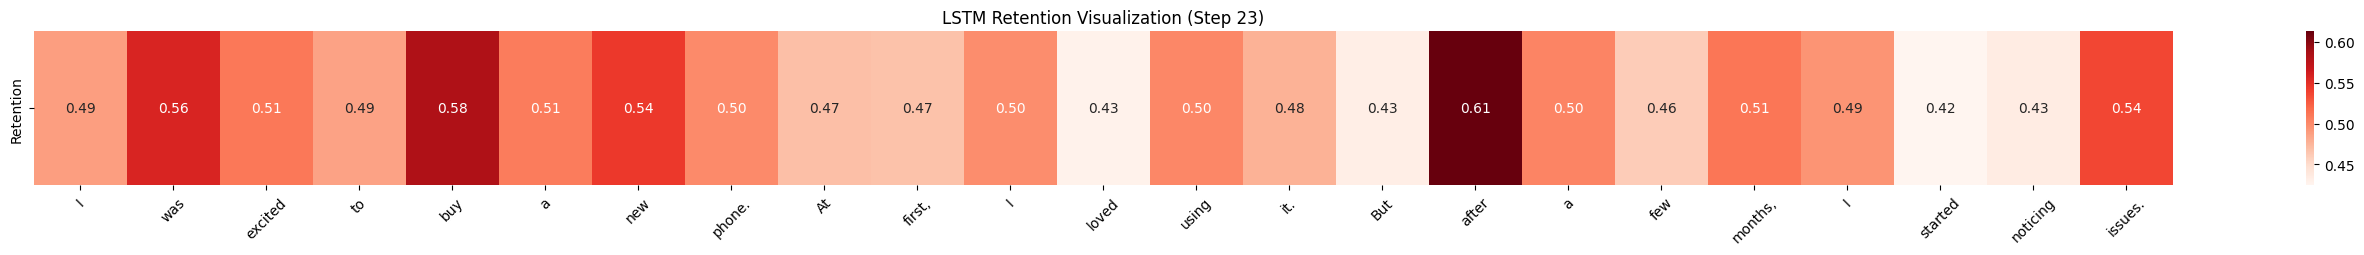

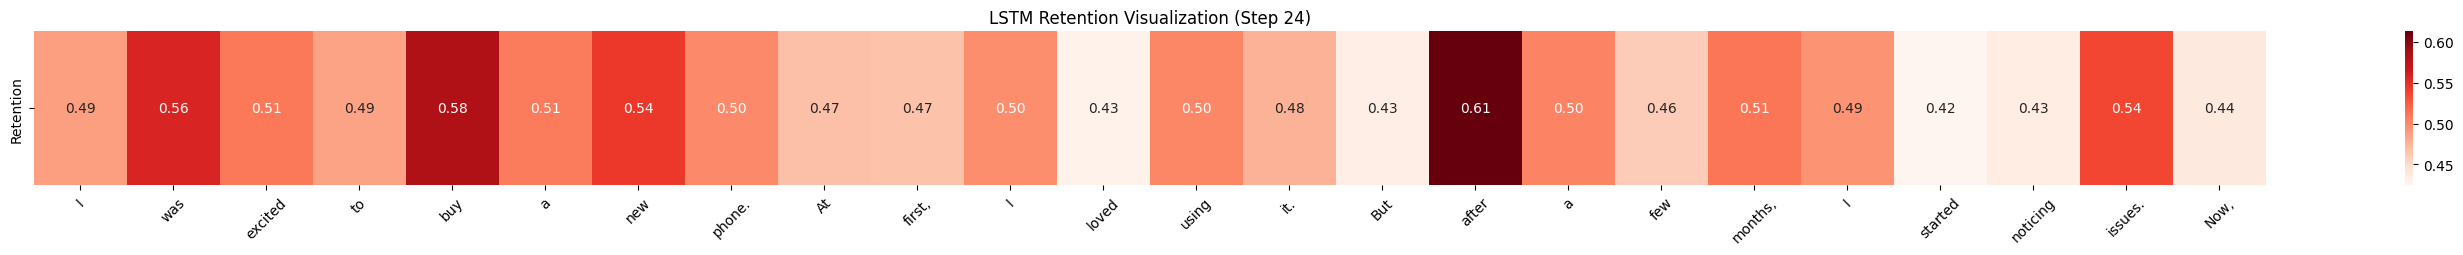

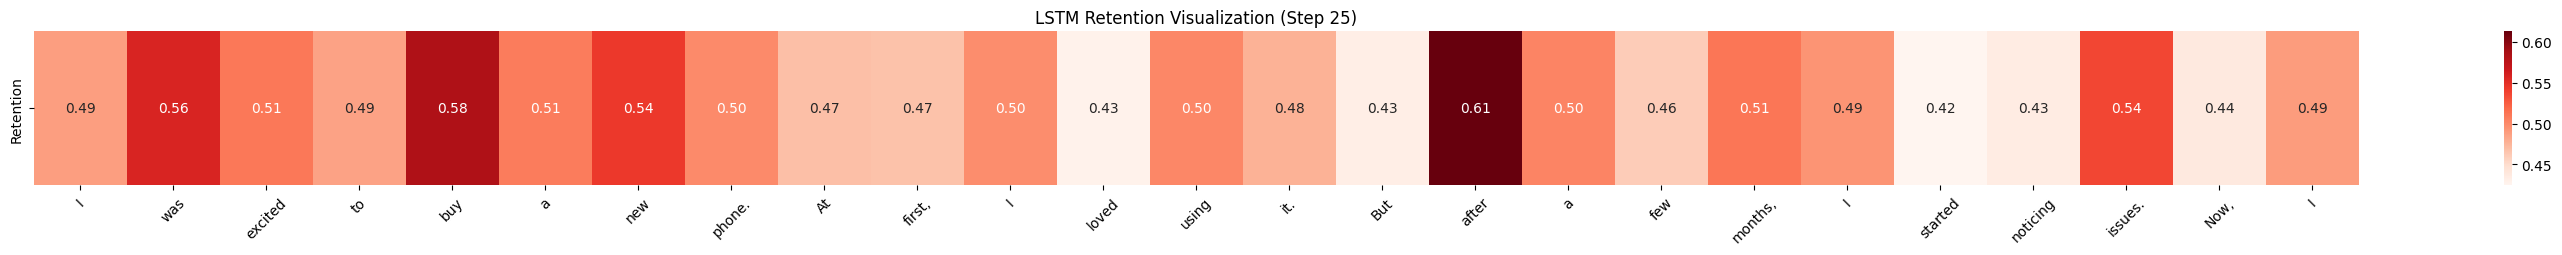

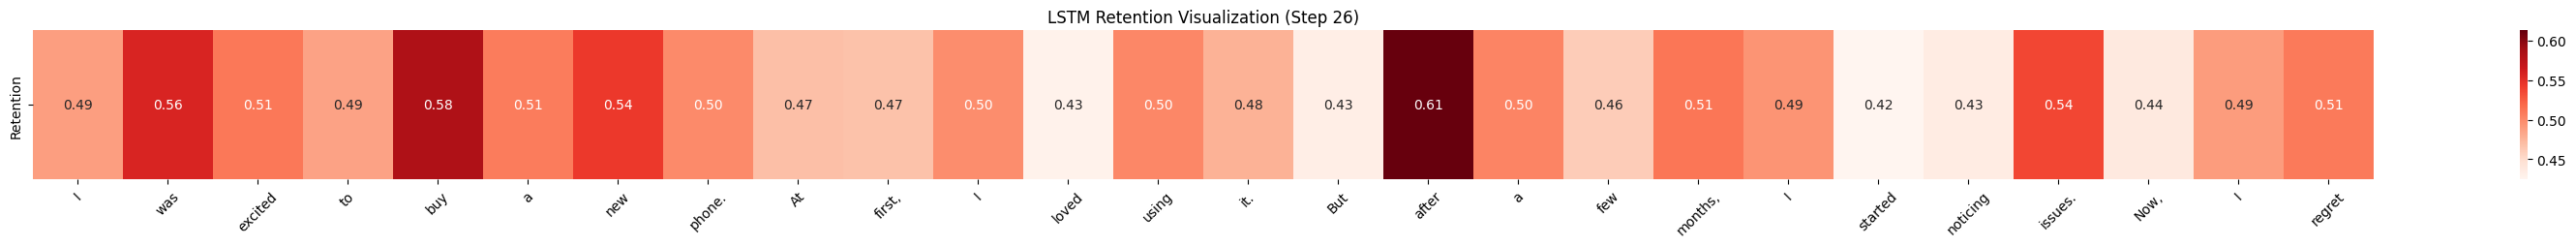

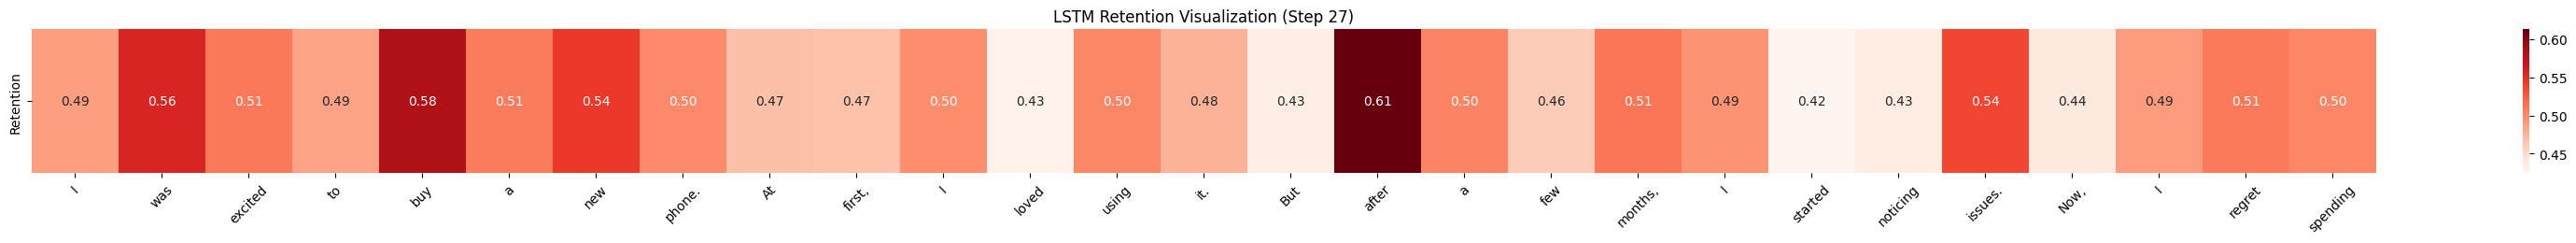

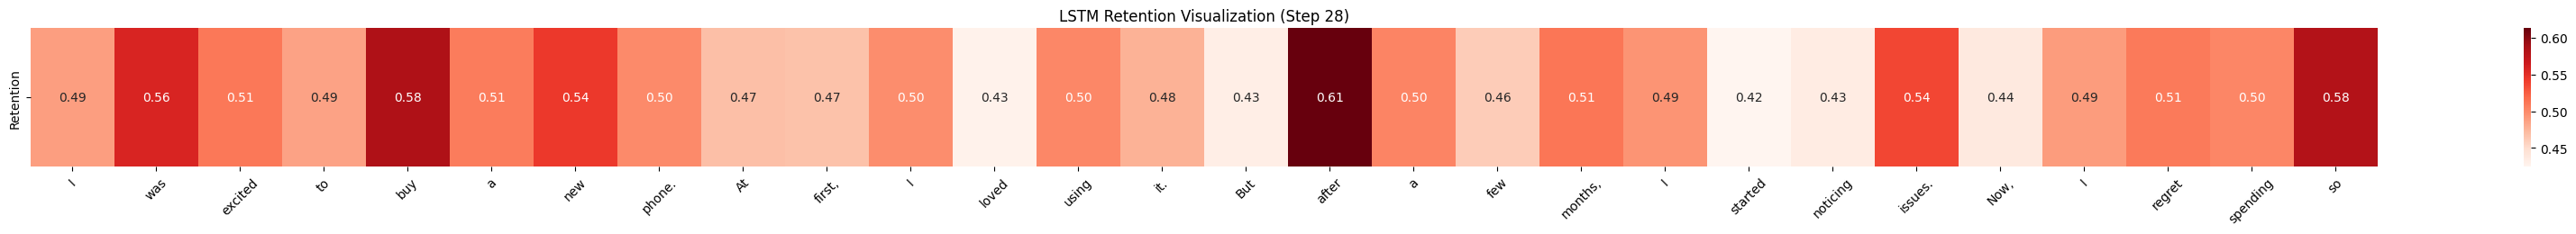

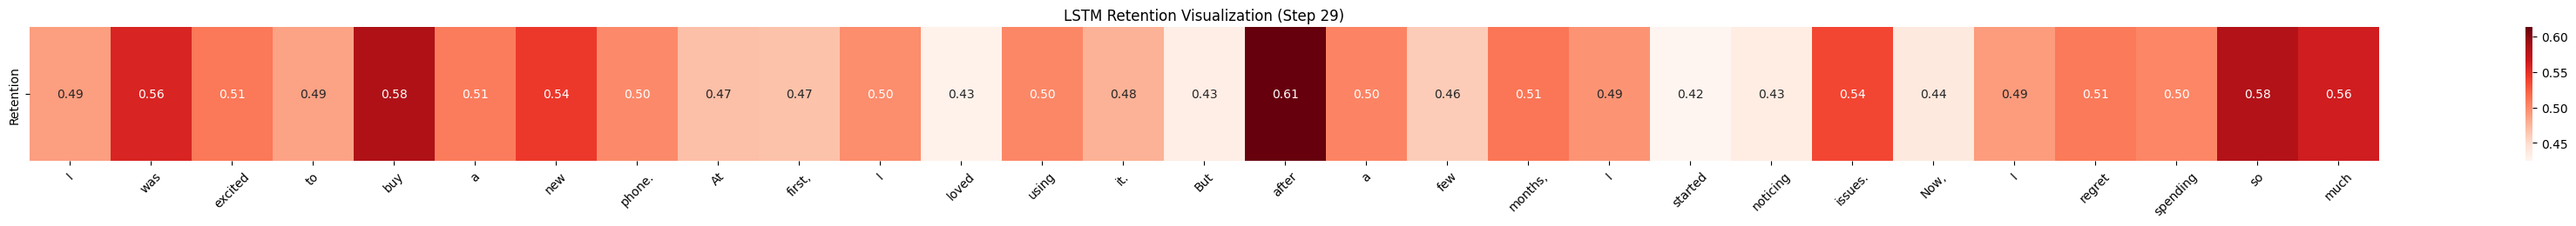

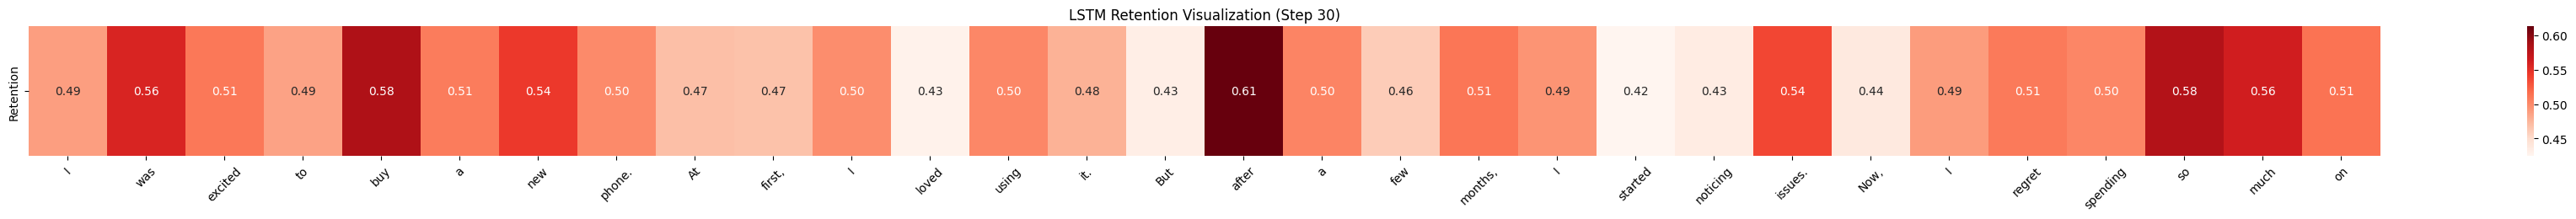

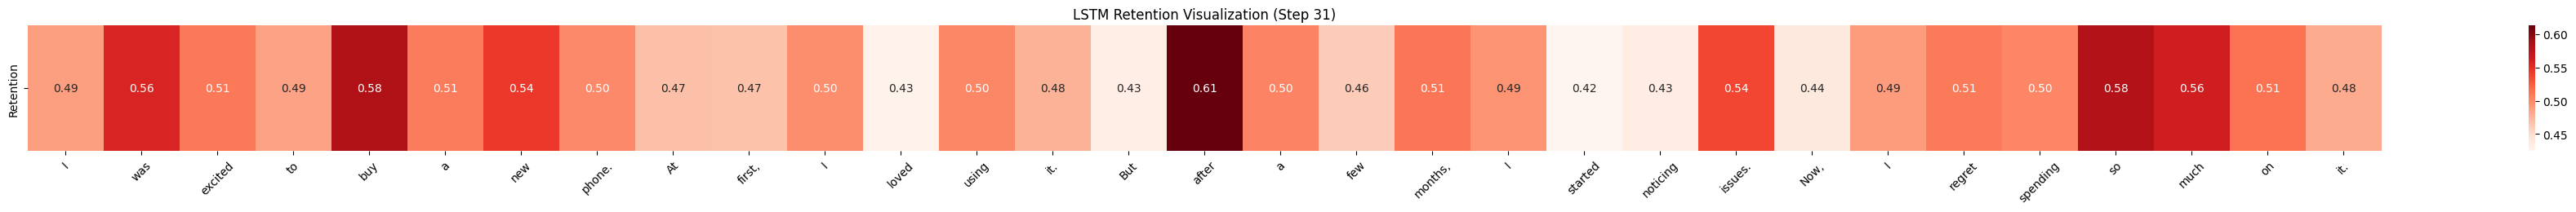

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Set a fixed seed for reproducibility
torch.manual_seed(42)

# Define the text and tokenize it (using a simple split)
text = ("I was excited to buy a new phone. At first, I loved using it. "
        "But after a few months, I started noticing issues. Now, I regret spending so much on it.")
words = text.split()

# Create a vocabulary mapping each unique word to an index
vocab = {word: idx for idx, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 8   # Size of each word embedding
hidden_size = 16    # Size of the LSTM hidden state

# Set the seed again before defining layers (ensures weights stay the same)
torch.manual_seed(42)

# Create an embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim)

# Define a custom LSTM cell to extract the internal gates and states
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Linear layers to compute gates from the input and previous hidden state
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, hidden):
        hx, cx = hidden
        # Compute the combined gate activations
        gates = self.x2h(x) + self.h2h(hx)
        # Split the activations into 4 parts:
        # input gate, forget gate, candidate cell state, and output gate.
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        # Apply activation functions
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        # Compute the new cell state and hidden state
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)

        # Return hidden state, cell state, and each gate
        return hy, cy, forgetgate, ingate, cellgate, outgate

# Instantiate the custom LSTM cell
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# Initialize hidden state and cell state (batch size is 1)
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# Store words and forget gate retention for visualization
words_list = []
forget_retention = []

# Process each word in the text
for step, word in enumerate(words):
    # Convert word to index and then to an embedding vector
    idx = torch.tensor([vocab[word]])
    x = embedding(idx)

    # Pass the embedding and current states through the LSTM cell
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    # Compute mean forget gate value (representing retention)
    forget_mean = f_gate.mean().item()

    # Store word and forget retention
    words_list.append(word)
    forget_retention.append(forget_mean)

    # ---- Progressive Heatmap ----
    plt.figure(figsize=(len(words_list) * 1.5, 2))  # Dynamic width
    sns.heatmap([forget_retention], annot=True, fmt=".2f", cmap="Reds",
                xticklabels=words_list, yticklabels=["Retention"])
    plt.xticks(rotation=45)
    plt.title(f"LSTM Retention Visualization (Step {step+1})")
    plt.show()


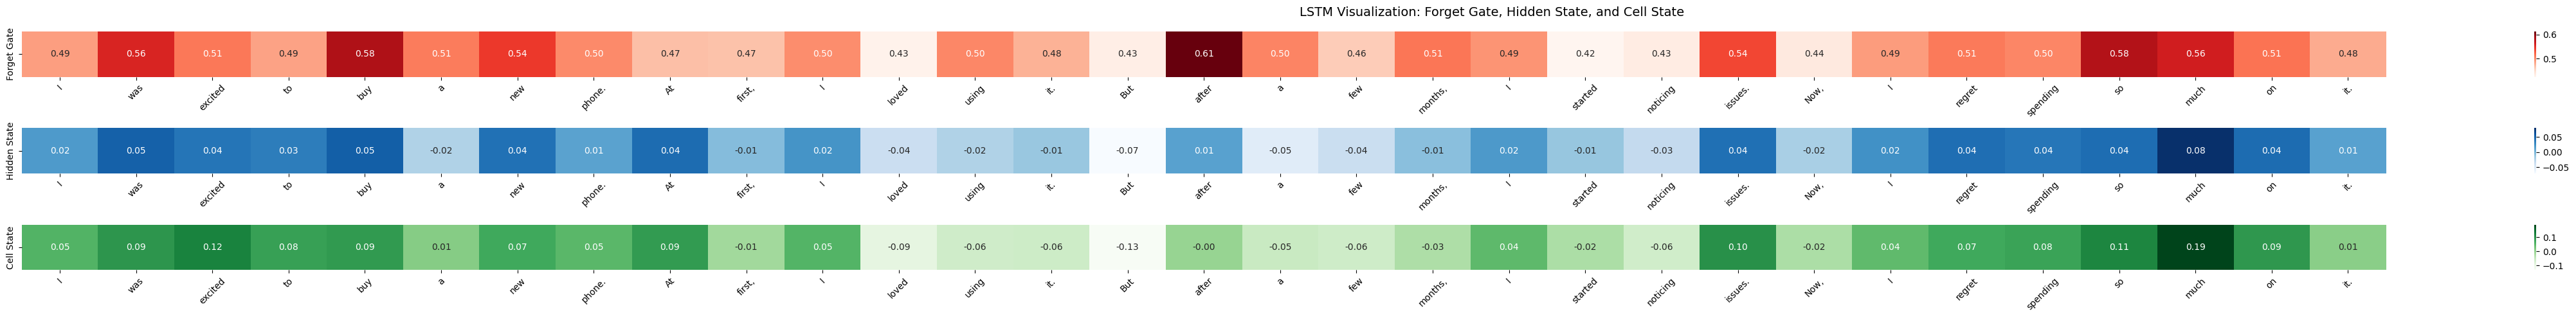

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Set a fixed seed for reproducibility
torch.manual_seed(42)

# Define the text and tokenize it (using a simple split)
text = ("I was excited to buy a new phone. At first, I loved using it. "
        "But after a few months, I started noticing issues. Now, I regret spending so much on it.")
words = text.split()

# Create a vocabulary mapping each unique word to an index
vocab = {word: idx for idx, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 8   # Size of each word embedding
hidden_size = 16    # Size of the LSTM hidden state

# Set the seed again before defining layers (ensures weights stay the same)
torch.manual_seed(42)

# Create an embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim)

# Define a custom LSTM cell to extract the internal gates and states
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Linear layers to compute gates from the input and previous hidden state
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, hidden):
        hx, cx = hidden
        # Compute the combined gate activations
        gates = self.x2h(x) + self.h2h(hx)
        # Split the activations into 4 parts:
        # input gate, forget gate, candidate cell state, and output gate.
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        # Apply activation functions
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        # Compute the new cell state and hidden state
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)

        # Return hidden state, cell state, and each gate
        return hy, cy, forgetgate, ingate, cellgate, outgate

# Instantiate the custom LSTM cell
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# Initialize hidden state and cell state (batch size is 1)
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# Store words and activations for visualization
words_list = []
forget_retention = []
hidden_activations = []
cell_activations = []

# Process each word in the text
for step, word in enumerate(words):
    # Convert word to index and then to an embedding vector
    idx = torch.tensor([vocab[word]])
    x = embedding(idx)

    # Pass the embedding and current states through the LSTM cell
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    # Compute mean values for visualization
    forget_mean = f_gate.mean().item()
    hidden_mean = h.mean().item()
    cell_mean = c.mean().item()

    # Store word and activations
    words_list.append(word)
    forget_retention.append(forget_mean)
    hidden_activations.append(hidden_mean)
    cell_activations.append(cell_mean)

# ---- Plot Multi-Row Heatmap ----
plt.figure(figsize=(len(words_list) * 1.5, 5))

# Forget Gate Heatmap
plt.subplot(3, 1, 1)
sns.heatmap([forget_retention], annot=True, fmt=".2f", cmap="Reds",
            xticklabels=words_list, yticklabels=["Forget Gate"])
plt.xticks(rotation=45)

# Hidden State Heatmap
plt.subplot(3, 1, 2)
sns.heatmap([hidden_activations], annot=True, fmt=".2f", cmap="Blues",
            xticklabels=words_list, yticklabels=["Hidden State"])
plt.xticks(rotation=45)

# Cell State Heatmap
plt.subplot(3, 1, 3)
sns.heatmap([cell_activations], annot=True, fmt=".2f", cmap="Greens",
            xticklabels=words_list, yticklabels=["Cell State"])
plt.xticks(rotation=45)

plt.suptitle("LSTM Visualization: Forget Gate, Hidden State, and Cell State", fontsize=14)
plt.tight_layout()
plt.show()


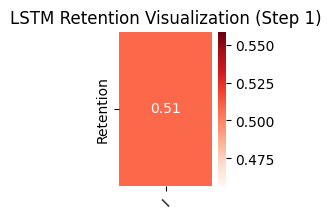

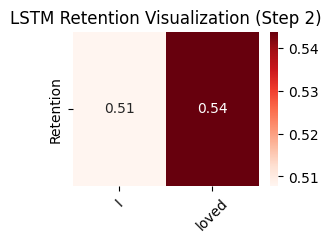

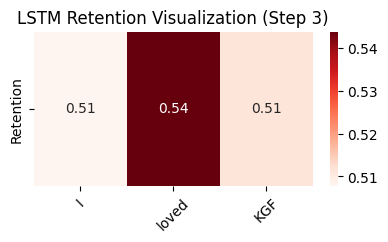

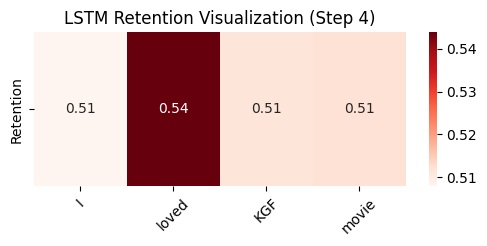

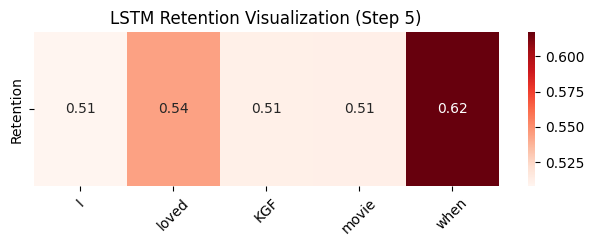

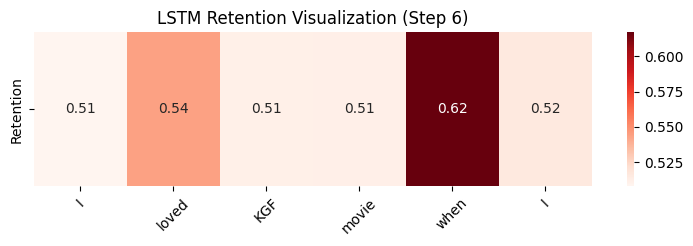

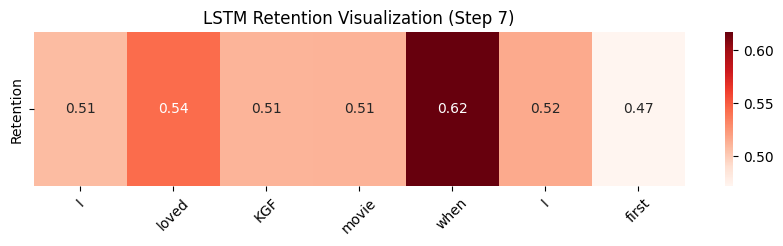

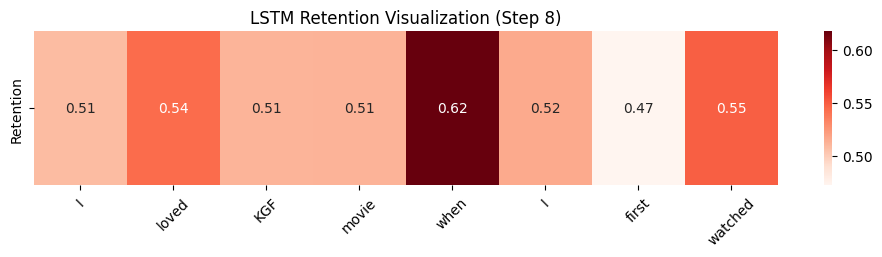

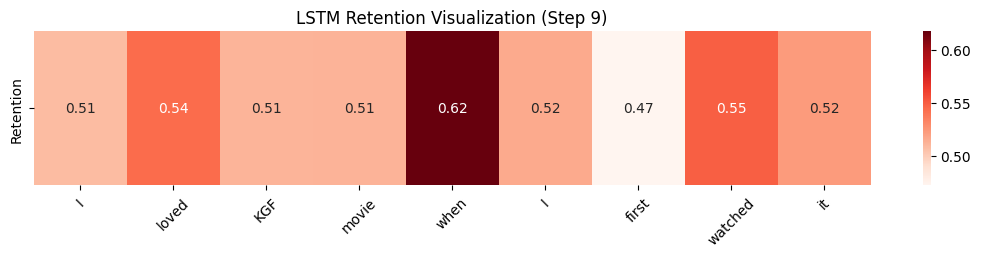

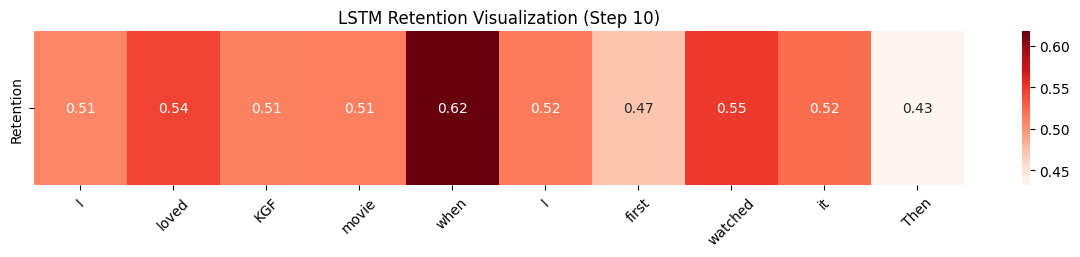

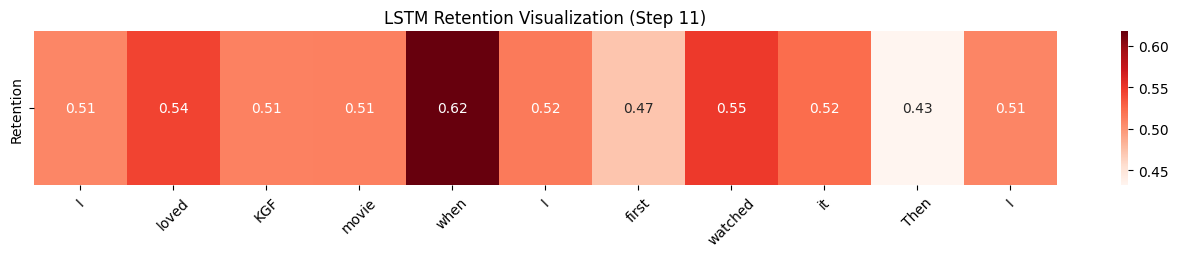

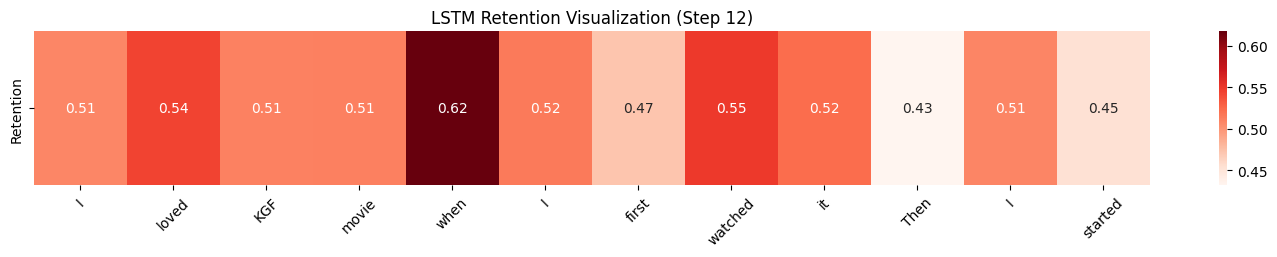

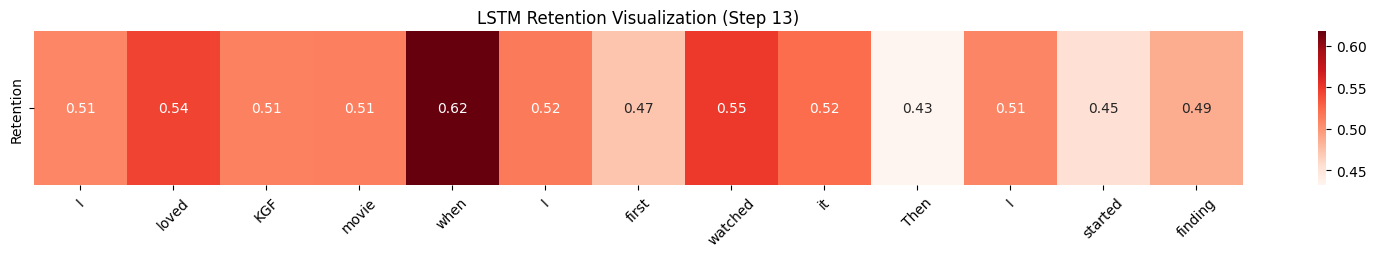

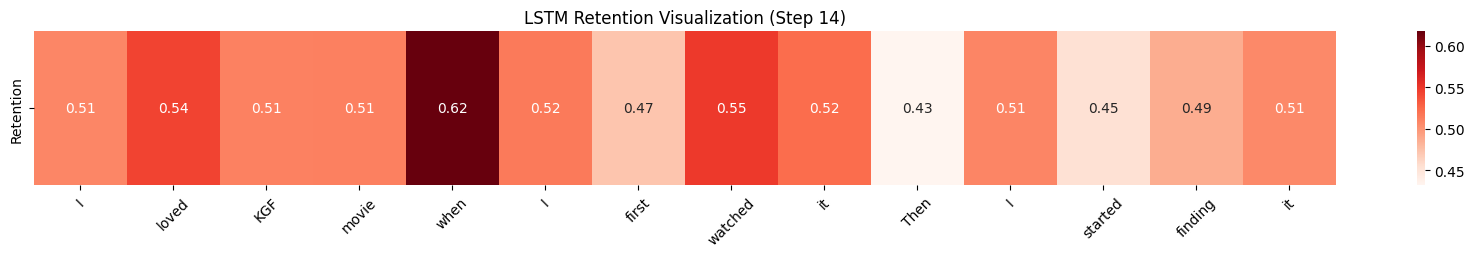

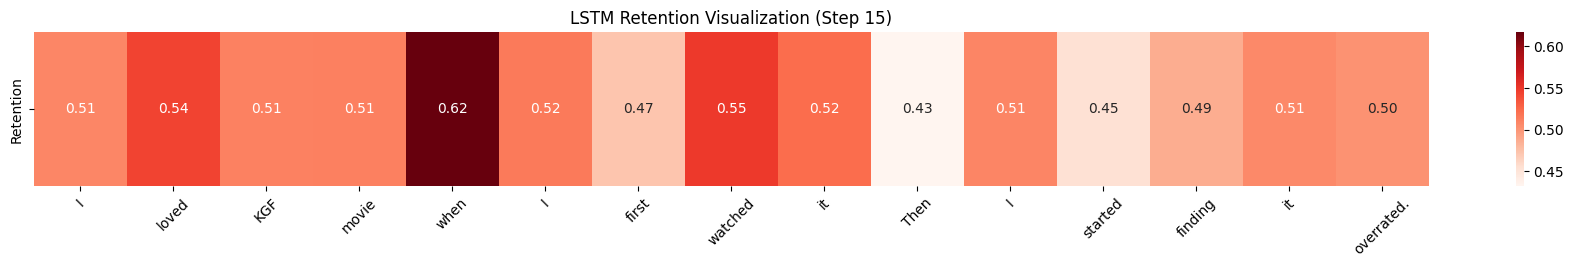

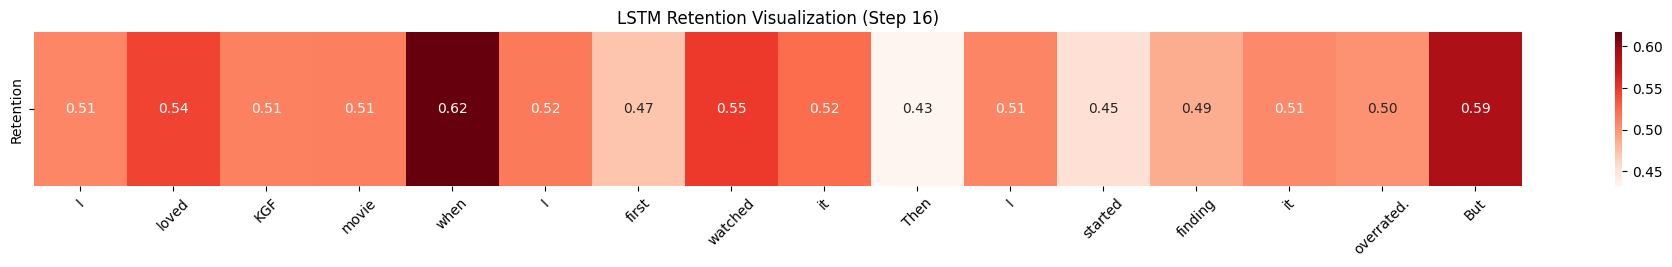

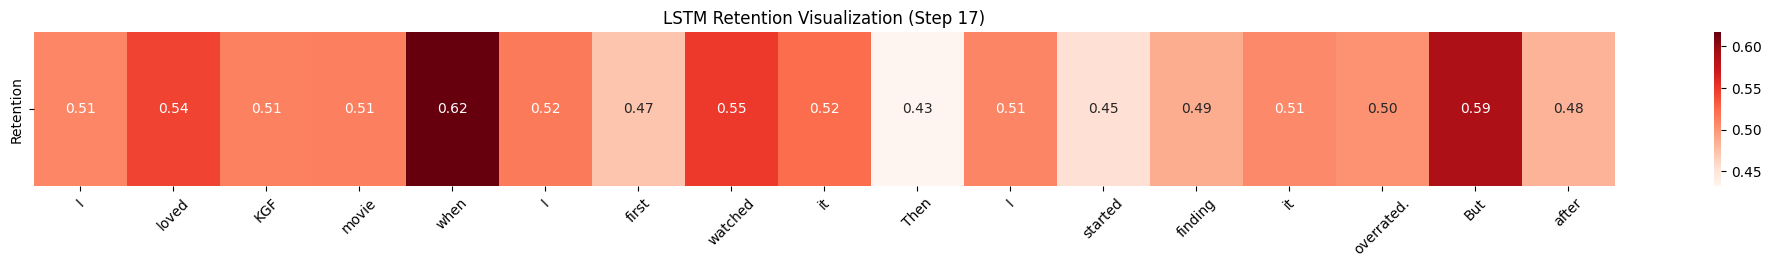

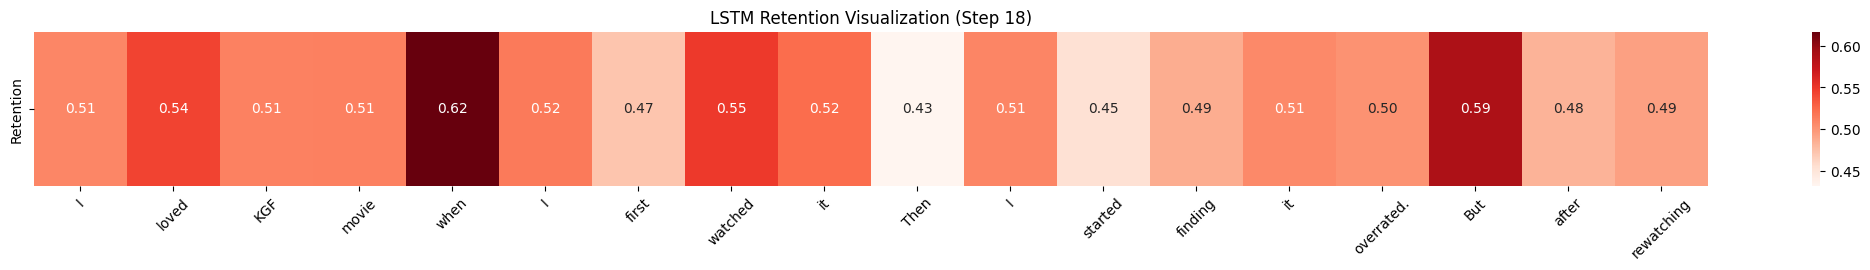

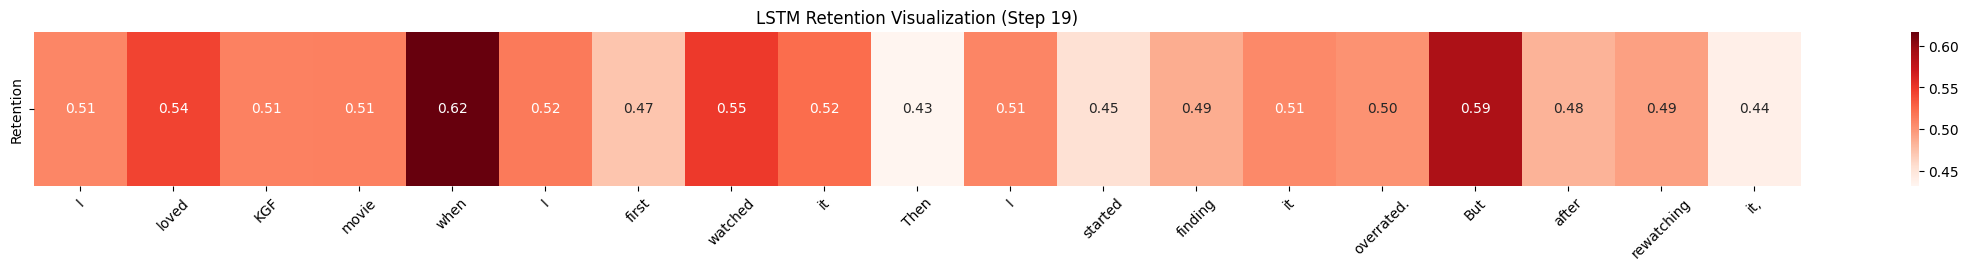

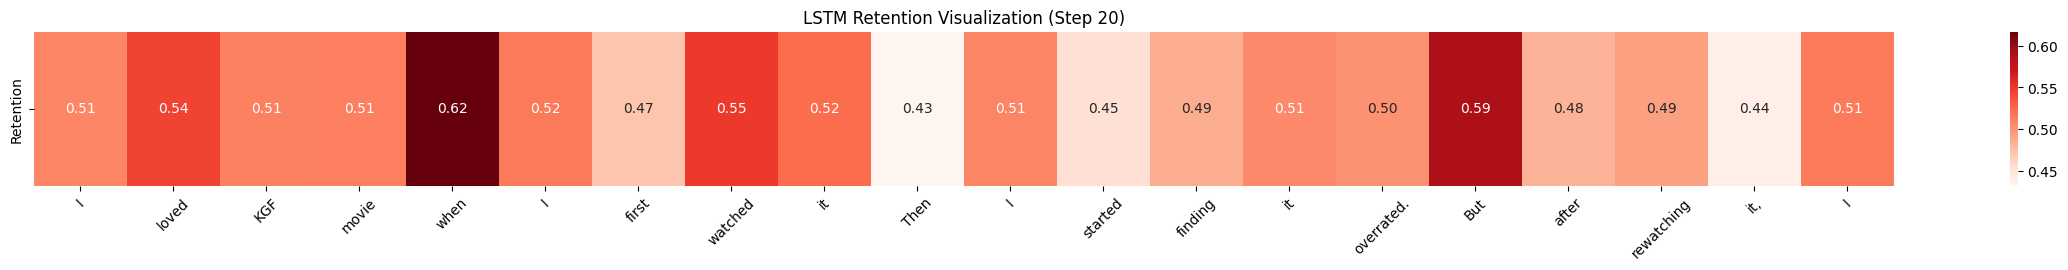

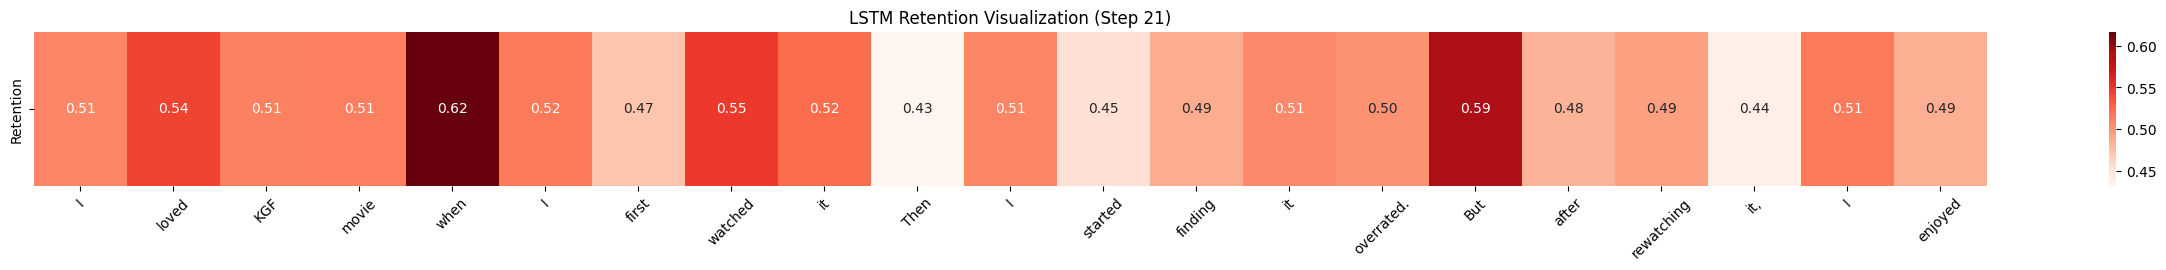

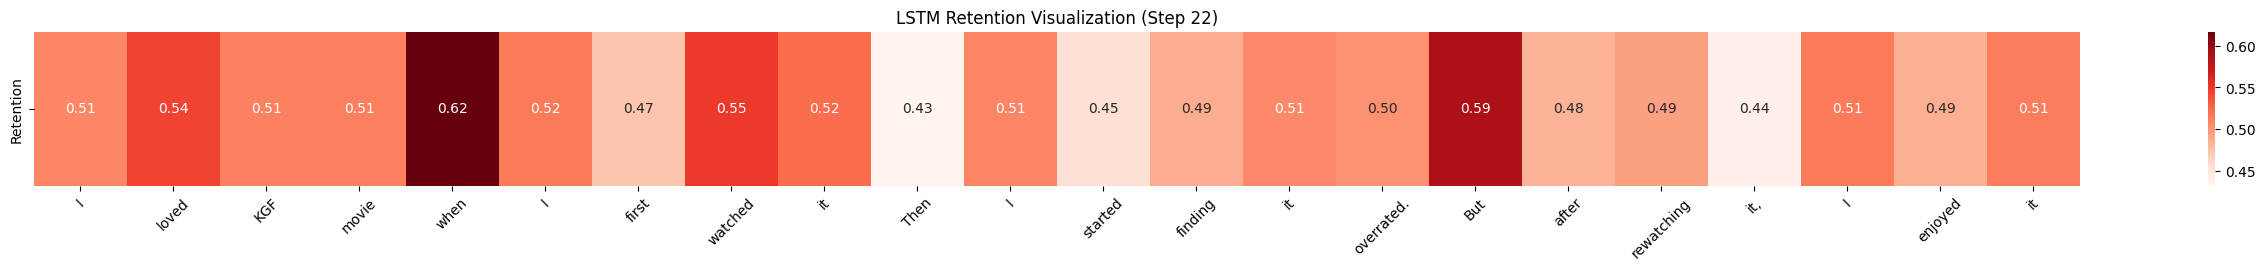

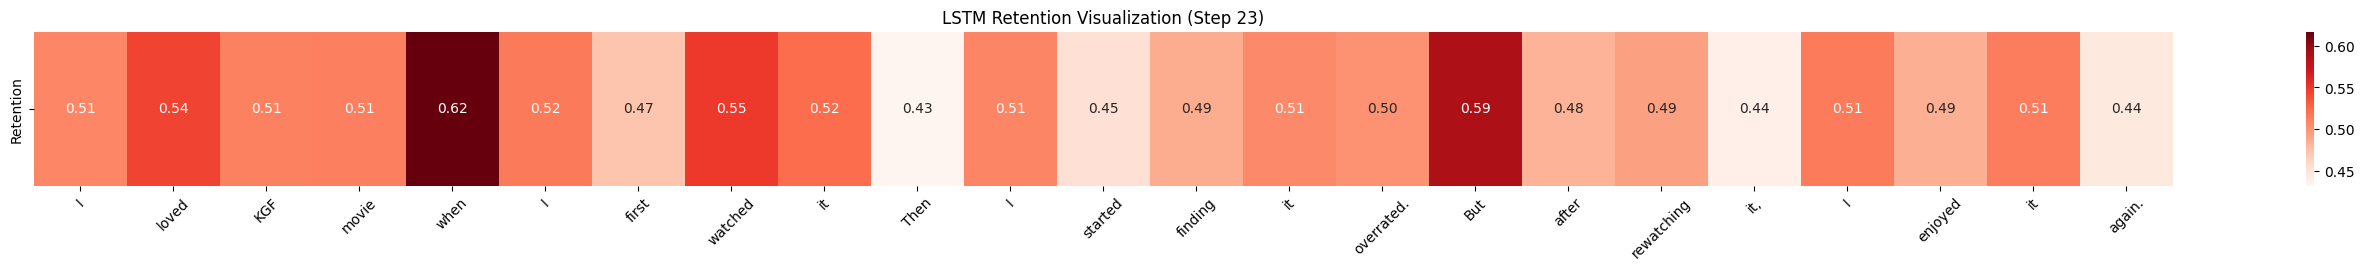

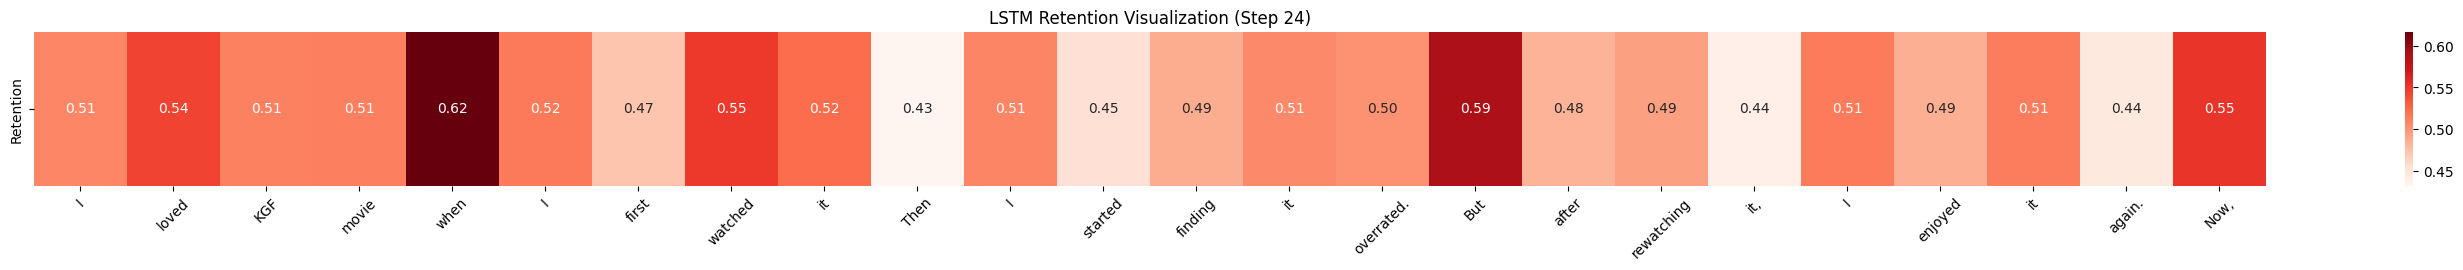

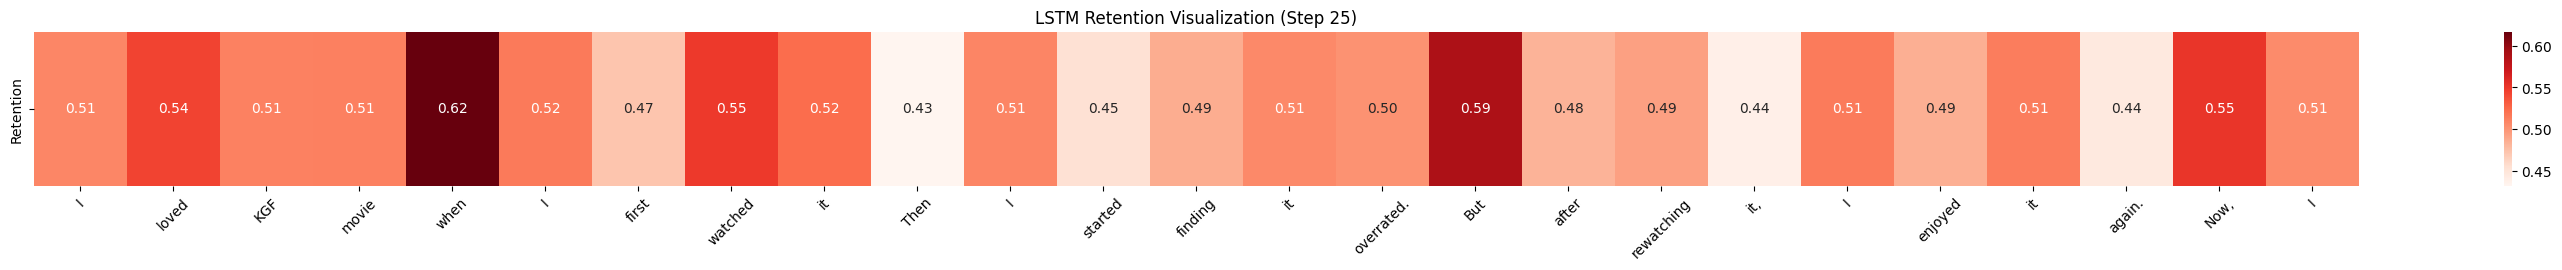

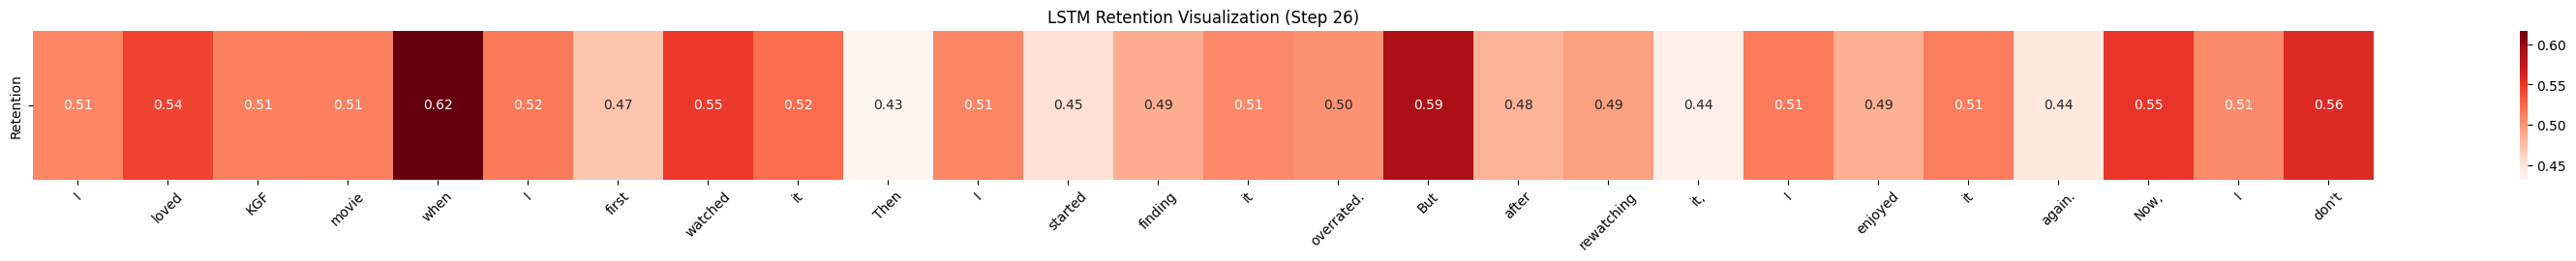

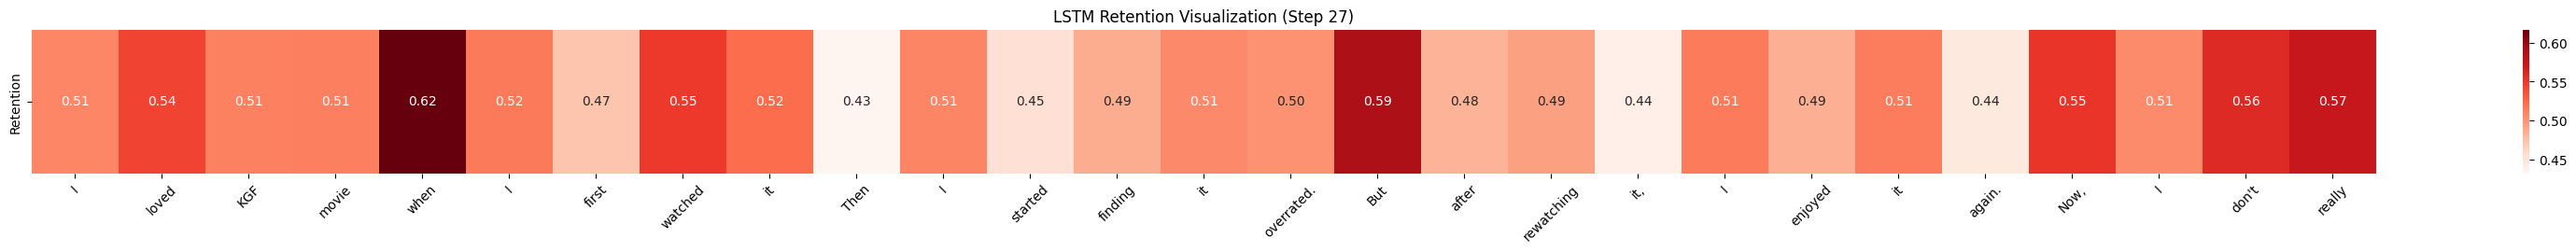

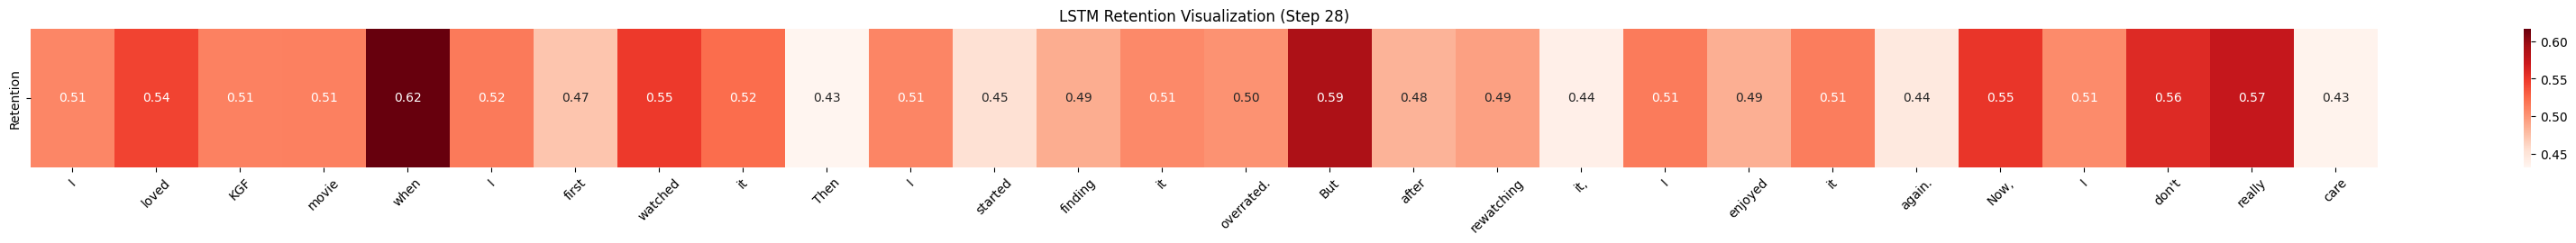

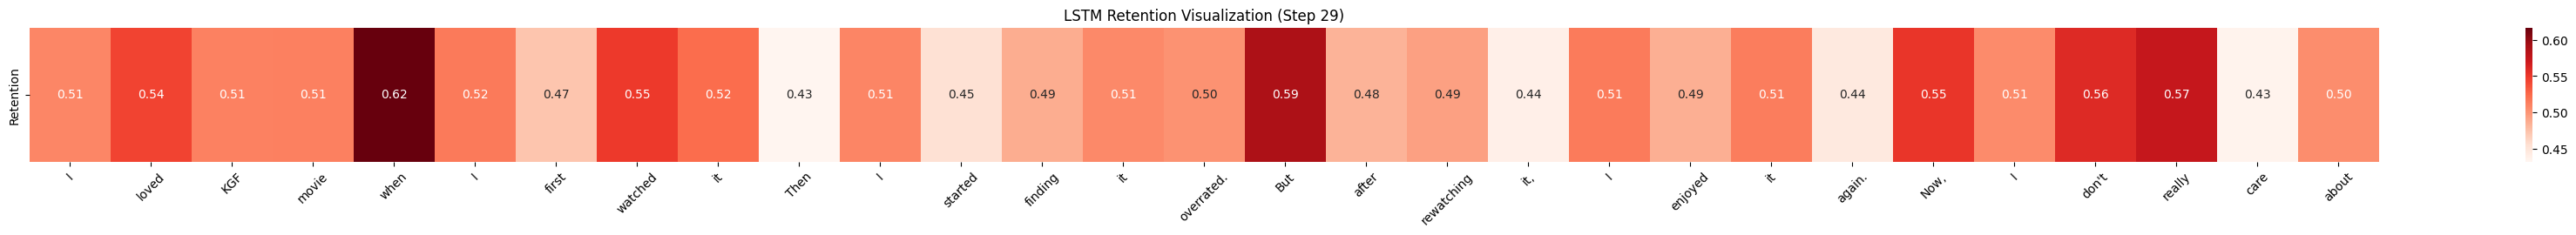

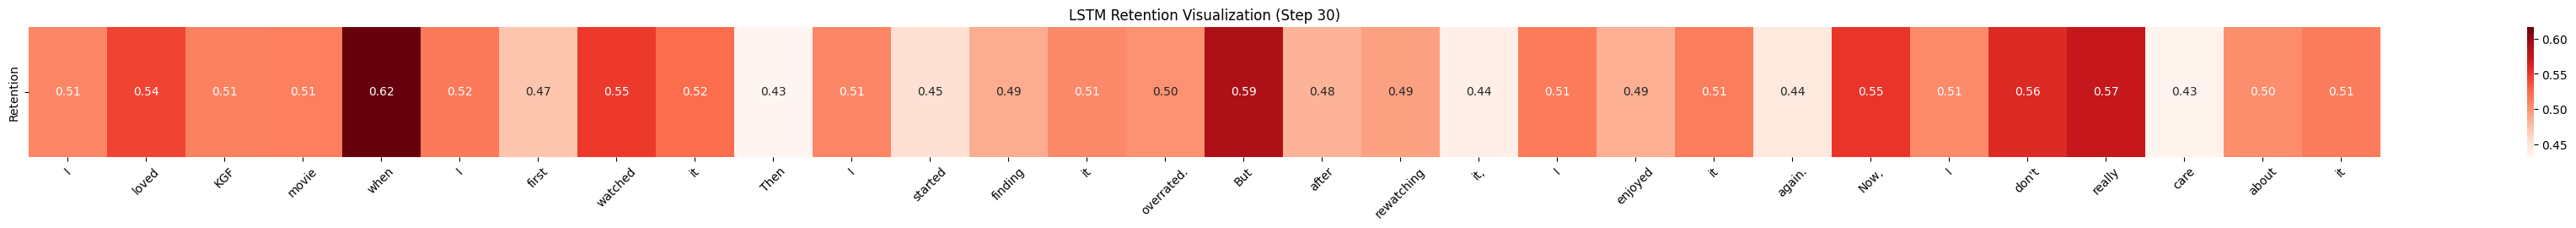

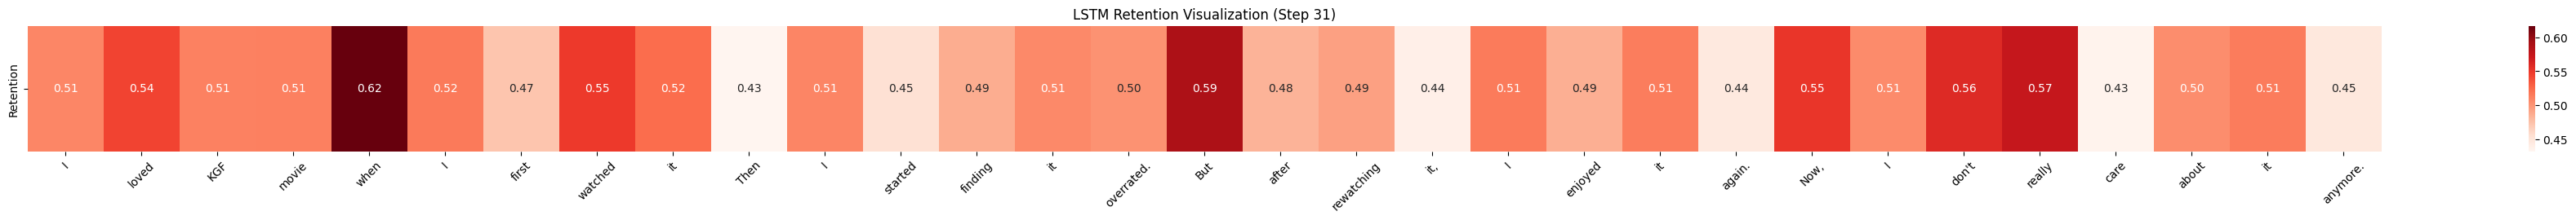

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Set a fixed seed for reproducibility
torch.manual_seed(42)

# Define the text and tokenize it (using a simple split)
text = ("I loved KGF movie when I first watched it Then I started finding it overrated. But after rewatching it, I enjoyed it again. Now, I don't really care about it anymore.")
words = text.split()

# Create a vocabulary mapping each unique word to an index
vocab = {word: idx for idx, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 8   # Size of each word embedding
hidden_size = 16    # Size of the LSTM hidden state

# Set the seed again before defining layers (ensures weights stay the same)
torch.manual_seed(42)

# Create an embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim)

# Define a custom LSTM cell to extract the internal gates and states
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Linear layers to compute gates from the input and previous hidden state
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, hidden):
        hx, cx = hidden
        # Compute the combined gate activations
        gates = self.x2h(x) + self.h2h(hx)
        # Split the activations into 4 parts:
        # input gate, forget gate, candidate cell state, and output gate.
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        # Apply activation functions
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        # Compute the new cell state and hidden state
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)

        # Return hidden state, cell state, and each gate
        return hy, cy, forgetgate, ingate, cellgate, outgate

# Instantiate the custom LSTM cell
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# Initialize hidden state and cell state (batch size is 1)
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# Store words and forget gate retention for visualization
words_list = []
forget_retention = []

# Process each word in the text
for step, word in enumerate(words):
    # Convert word to index and then to an embedding vector
    idx = torch.tensor([vocab[word]])
    x = embedding(idx)

    # Pass the embedding and current states through the LSTM cell
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    # Compute mean forget gate value (representing retention)
    forget_mean = f_gate.mean().item()

    # Store word and forget retention
    words_list.append(word)
    forget_retention.append(forget_mean)

    # ---- Progressive Heatmap ----
    plt.figure(figsize=(len(words_list) * 1.5, 2))  # Dynamic width
    sns.heatmap([forget_retention], annot=True, fmt=".2f", cmap="Reds",
                xticklabels=words_list, yticklabels=["Retention"])
    plt.xticks(rotation=45)
    plt.title(f"LSTM Retention Visualization (Step {step+1})")
    plt.show()


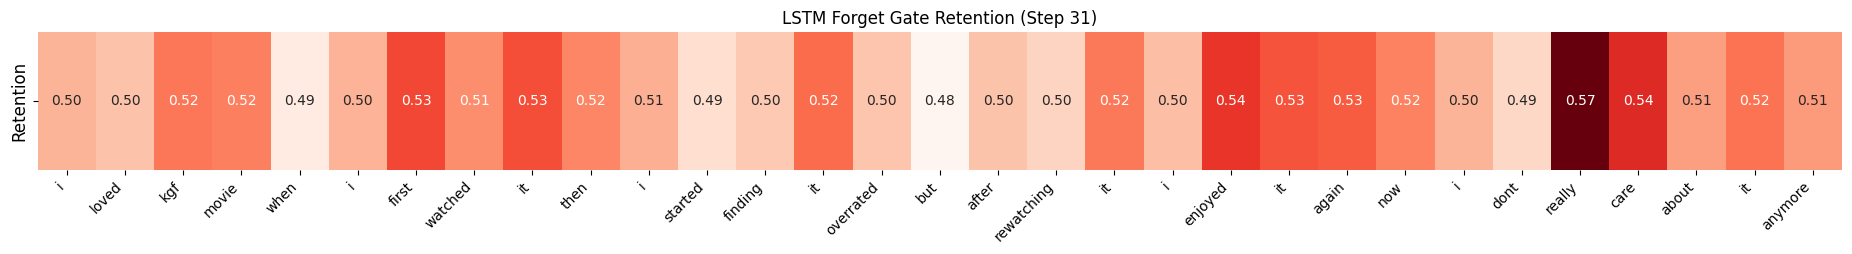

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

# 🔹 **Fix the random seed for reproducibility**
np.random.seed(42)
torch.manual_seed(42)

# Sample sentence
sentence = "i loved kgf movie when i first watched it then i started finding it overrated but after rewatching it i enjoyed it again now i dont really care about it anymore"
words = sentence.replace(',', '').split()

# Create vocabulary
vocab = {word: i for i, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 5
hidden_size = 10

# 🔹 **Using PyTorch's Learnable Word Embeddings Instead of Random Values**
embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# Convert words to tensor indices
word_indices = torch.tensor([vocab[word] for word in words], dtype=torch.long)

# Get word embeddings from the embedding layer
input_tensor = embedding_layer(word_indices)

# 🔹 **Custom LSTM cell to extract hidden, cell state, and forget gate values**
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, hidden):
        hx, cx = hidden
        gates = self.x2h(x) + self.h2h(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)
        return hy, cy, forgetgate, ingate, cellgate, outgate

# Instantiate LSTM
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# Initialize hidden state and cell state (batch size = 1)
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# Store words and forget gate retention for visualization
words_list = []
forget_retention = []

# Process each word in the text
for step, word in enumerate(words):
    idx = torch.tensor([vocab[word]])
    x = embedding_layer(idx)
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))
    forget_mean = f_gate.mean().item()
    words_list.append(word)
    forget_retention.append(forget_mean)

# ---- Fix Figure Size and Animation ----
fig, ax = plt.subplots(figsize=(len(words_list) * 0.6, 2.5))  # Increased height slightly

def init():
    ax.clear()
    sns.heatmap(np.zeros((1, len(words_list))), annot=False, cmap="Reds",
                xticklabels=words_list, yticklabels=["Retention"], ax=ax, cbar=False)
    ax.set_xticklabels(words_list, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(["Retention"], fontsize=10)
    ax.set_title("LSTM Forget Gate Retention Animation", fontsize=12)
    plt.tight_layout()  # 🔹 Ensures everything fits properly

def update(frame):
    ax.clear()
    sns.heatmap([forget_retention[:frame + 1]], annot=True, fmt=".2f", cmap="Reds",
                xticklabels=words_list[:frame + 1], yticklabels=["Retention"], ax=ax, cbar=False)
    ax.set_xticklabels(words_list[:frame + 1], rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(["Retention"], fontsize=12)
    ax.set_title(f"LSTM Forget Gate Retention (Step {frame+1})", fontsize=12)
    plt.xticks(rotation=45)  # 🔹 Ensure rotation is applied correctly
    plt.subplots_adjust(bottom=0.3)  # 🔹 Adjust bottom margin to prevent cut-off

# 🔹 **Create the animation**
ani = animation.FuncAnimation(fig, update, frames=len(words_list), init_func=init, interval=800, repeat=False)

# 🔹 **Display animation properly in Jupyter Notebook**
HTML(ani.to_jshtml())

# 🔹 **To save the animation as a GIF (Fixed Layout)**
ani.save('lstm_forget_gate_animation_fixed.gif', writer='pillow', dpi=150)

# 🔹 **For Python script execution, show the animation**
plt.show()


'lstm_states_animation.gif'

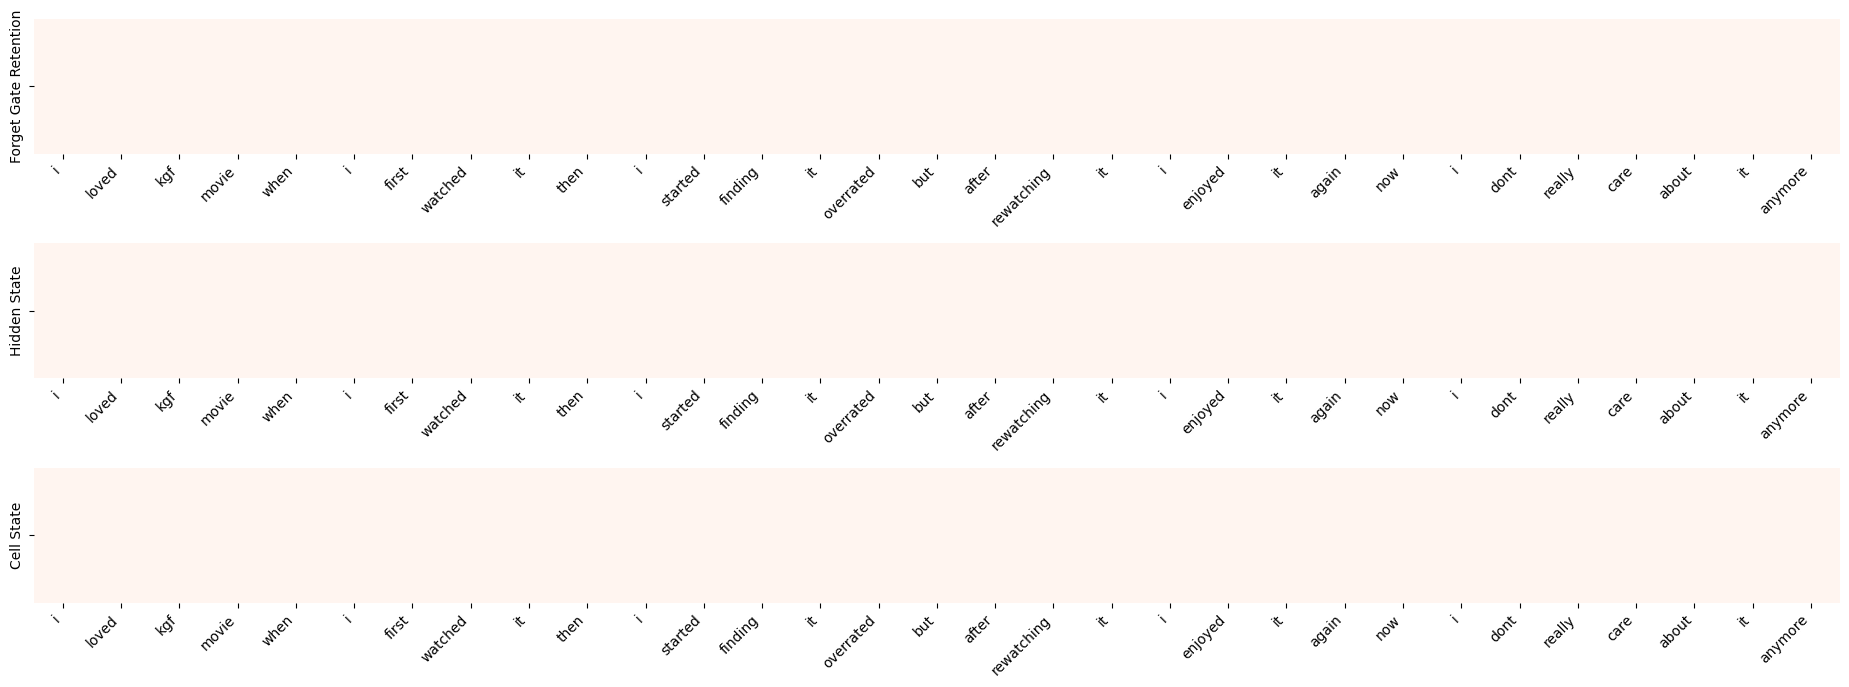

In [2]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML




# Fix random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Sample sentence
sentence = "i loved kgf movie when i first watched it then i started finding it overrated but after rewatching it i enjoyed it again now i dont really care about it anymore"
words = sentence.replace(',', '').split()

# Create vocabulary
vocab = {word: i for i, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 5
hidden_size = 10

# Using PyTorch's Learnable Word Embeddings
embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# Ensure embedding layer has fixed weights for consistency
embedding_layer.weight.data.uniform_(-0.1, 0.1)

# Convert words to tensor indices
word_indices = torch.tensor([vocab[word] for word in words], dtype=torch.long)

# Custom LSTM cell to extract hidden, cell state, and forget gate values
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)
        self.reset_parameters()  # Ensuring deterministic initialization

    def reset_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.1, 0.1)  # Ensuring same weight initialization

    def forward(self, x, hidden):
        hx, cx = hidden
        gates = self.x2h(x) + self.h2h(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)
        return hy, cy, forgetgate, ingate, cellgate, outgate

# Instantiate LSTM
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# Initialize hidden state and cell state (batch size = 1)
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# Store values for visualization
words_list = []
forget_retention = []
hidden_state_values = []
cell_state_values = []

# Process each word in the text
for step, word in enumerate(words):
    idx = torch.tensor([vocab[word]])
    x = embedding_layer(idx)
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    forget_mean = f_gate.mean().item()
    hidden_mean = h.mean().item()
    cell_mean = c.mean().item()

    words_list.append(word)
    forget_retention.append(forget_mean)
    hidden_state_values.append(hidden_mean)
    cell_state_values.append(cell_mean)

# ---- Create Animation ----
fig, axes = plt.subplots(3, 1, figsize=(len(words_list) * 0.6, 7))

titles = ["Forget Gate Retention", "Hidden State", "Cell State"]
data = [forget_retention, hidden_state_values, cell_state_values]
cmaps = ["Reds", "Blues", "Greens"]

def init():
    for ax, title in zip(axes, titles):
        ax.clear()
        sns.heatmap(np.zeros((1, len(words_list))), annot=False, cmap="Reds",
                    xticklabels=words_list, yticklabels=[title], ax=ax, cbar=False)
        ax.set_xticklabels(words_list, rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels([title], fontsize=10)
    plt.tight_layout()

def update(frame):
    for ax, title, values, cmap in zip(axes, titles, data, cmaps):
        ax.clear()
        sns.heatmap([values[:frame + 1]], annot=True, fmt=".2f", cmap=cmap,
                    xticklabels=words_list[:frame + 1], yticklabels=[title], ax=ax, cbar=False)
        ax.set_xticklabels(words_list[:frame + 1], rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels([title], fontsize=12)
    plt.tight_layout()

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(words_list), init_func=init, interval=800, repeat=False)

# Save animation
animation_path = "lstm_states_animation.gif"
ani.save(animation_path, writer='pillow', dpi=150)

# Display the animation path
animation_path


In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

# 🔹 Fix Random Seed for Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 🔹 Sample Sentence
sentence = "i loved kgf movie when i first watched it then i started finding it overrated but after rewatching it i enjoyed it again now i dont really care about it anymore"
words = sentence.replace(',', '').split()

# 🔹 Create Vocabulary
vocab = {word: i for i, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 5
hidden_size = 10  # Can reduce to 5 if memory issues occur

# 🔹 Define Learnable Word Embeddings with Fixed Weights
embedding_layer = nn.Embedding(vocab_size, embedding_dim)
embedding_layer.weight.data.uniform_(-0.1, 0.1)  # Fix initialization

# Convert Words to Tensor Indices
word_indices = torch.tensor([vocab[word] for word in words], dtype=torch.long)

# 🔹 Custom LSTM Cell to Extract Hidden, Cell State, and Forget Gate Values
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)
        self.reset_parameters()  # Ensuring deterministic initialization

    def reset_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.1, 0.1)  # Ensuring same weight initialization

    def forward(self, x, hidden):
        hx, cx = hidden
        gates = self.x2h(x) + self.h2h(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)
        return hy, cy, forgetgate, ingate, cellgate, outgate

# 🔹 Instantiate LSTM
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# 🔹 Initialize Hidden State and Cell State
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# 🔹 Store Values for Visualization
words_list = []
forget_retention = []
hidden_state_values = []
cell_state_values = []

# 🔹 Process Each Word in the Text
for step, word in enumerate(words):
    idx = torch.tensor([vocab[word]])
    x = embedding_layer(idx)
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    forget_mean = f_gate.mean().item()
    hidden_mean = h.mean().item()
    cell_mean = c.mean().item()

    words_list.append(word)
    forget_retention.append(forget_mean)
    hidden_state_values.append(hidden_mean)
    cell_state_values.append(cell_mean)

# 🔹 Function to Create and Save Heatmap Animations
def create_and_save_animation(data, title, cmap, save_path):
    fig, ax = plt.subplots(figsize=(len(words_list) * 0.6, 2.5))

    def init():
        ax.clear()
        sns.heatmap(np.zeros((1, len(words_list))), annot=False, cmap=cmap,
                    xticklabels=words_list, yticklabels=[title], ax=ax, cbar=False)
        ax.set_xticklabels(words_list, rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels([title], fontsize=10)
        plt.tight_layout()

    def update(frame):
        ax.clear()
        sns.heatmap([data[:frame + 1]], annot=True, fmt=".2f", cmap=cmap,
                    xticklabels=words_list[:frame + 1], yticklabels=[title], ax=ax, cbar=False)
        ax.set_xticklabels(words_list[:frame + 1], rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels([title], fontsize=12)
        plt.tight_layout()

    ani = animation.FuncAnimation(fig, update, frames=len(words_list), init_func=init, interval=800, repeat=False)
    ani.save(save_path, writer='pillow', dpi=100)
    plt.close(fig)  # Close figure to free memory

# 🔹 Define File Paths for GIFs
forget_gate_gif_path = "forget_gate_animation.gif"
hidden_state_gif_path = "hidden_state_animation.gif"
cell_state_gif_path = "cell_state_animation.gif"

# 🔹 Generate and Save Animations Separately
create_and_save_animation(forget_retention, "Forget Gate Retention", "Reds", forget_gate_gif_path)
create_and_save_animation(hidden_state_values, "Hidden State", "Blues", hidden_state_gif_path)
create_and_save_animation(cell_state_values, "Cell State", "Greens", cell_state_gif_path)

# 🔹 Return Paths to Saved GIFs
forget_gate_gif_path, hidden_state_gif_path, cell_state_gif_path


('forget_gate_animation.gif',
 'hidden_state_animation.gif',
 'cell_state_animation.gif')

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

# 🔹 Fix Random Seed for Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 🔹 Sample Sentence
sentence = "i loved kgf movie when i first watched it then i started finding it overrated but after rewatching it i enjoyed it again now i dont really care about it anymore"
words = sentence.replace(',', '').split()

# 🔹 Create Vocabulary
vocab = {word: i for i, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 5
hidden_size = 10  # Can reduce to 5 if memory issues occur

# 🔹 Define Learnable Word Embeddings with Fixed Weights
embedding_layer = nn.Embedding(vocab_size, embedding_dim)
embedding_layer.weight.data.normal_(0, 0.1)  # Normal distribution for stability

# Convert Words to Tensor Indices
word_indices = torch.tensor([vocab[word] for word in words], dtype=torch.long)

# 🔹 Custom LSTM Cell to Extract Hidden, Cell State, and Forget Gate Values
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)
        self.reset_parameters()  # Ensuring proper weight initialization

    def reset_parameters(self):
        for param in self.parameters():
            if len(param.shape) > 1:  # Xavier for weight matrices
                nn.init.xavier_uniform_(param)
            else:  # Zero for biases
                param.data.fill_(0)

    def forward(self, x, hidden):
        hx, cx = hidden
        gates = self.x2h(x) + self.h2h(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)
        return hy, cy, forgetgate, ingate, cellgate, outgate

# 🔹 Instantiate LSTM with Correct Initialization
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# 🔹 Initialize Hidden State and Cell State with Small Random Values
h = torch.randn(1, hidden_size) * 0.01
c = torch.randn(1, hidden_size) * 0.01

# 🔹 Store Values for Visualization
words_list = []
forget_retention = []
hidden_state_values = []
cell_state_values = []

# 🔹 Process Each Word in the Text
for step, word in enumerate(words):
    idx = torch.tensor([vocab[word]])
    x = embedding_layer(idx)
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    forget_mean = f_gate.mean().item()
    hidden_mean = h.mean().item()
    cell_mean = c.mean().item()

    words_list.append(word)
    forget_retention.append(forget_mean)
    hidden_state_values.append(hidden_mean)
    cell_state_values.append(cell_mean)

# 🔹 Function to Create and Save Heatmap Animations
def create_and_save_animation(data, title, cmap, save_path):
    fig, ax = plt.subplots(figsize=(len(words_list) * 0.6, 2.5))

    def init():
        ax.clear()
        sns.heatmap(np.zeros((1, len(words_list))), annot=False, cmap=cmap,
                    xticklabels=words_list, yticklabels=[title], ax=ax, cbar=False)
        ax.set_xticklabels(words_list, rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels([title], fontsize=10)
        plt.tight_layout()

    def update(frame):
        ax.clear()
        sns.heatmap([data[:frame + 1]], annot=True, fmt=".2f", cmap=cmap,
                    xticklabels=words_list[:frame + 1], yticklabels=[title], ax=ax, cbar=False)
        ax.set_xticklabels(words_list[:frame + 1], rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels([title], fontsize=12)
        plt.tight_layout()

    ani = animation.FuncAnimation(fig, update, frames=len(words_list), init_func=init, interval=800, repeat=False)
    ani.save(save_path, writer='pillow', dpi=100)
    plt.close(fig)  # Close figure to free memory

# 🔹 Define File Paths for GIFs
forget_gate_gif_path = "fforget_gate_animation.gif"
hidden_state_gif_path = "hhidden_state_animation.gif"
cell_state_gif_path = "ecell_state_animation.gif"

# 🔹 Generate and Save Animations Separately
create_and_save_animation(forget_retention, "Forget Gate Retention", "Reds", forget_gate_gif_path)
create_and_save_animation(hidden_state_values, "Hidden State", "Blues", hidden_state_gif_path)
create_and_save_animation(cell_state_values, "Cell State", "Greens", cell_state_gif_path)

# 🔹 Return Paths to Saved GIFs
forget_gate_gif_path, hidden_state_gif_path, cell_state_gif_path


('fforget_gate_animation.gif',
 'hhidden_state_animation.gif',
 'ecell_state_animation.gif')

'combined_gates_animation.gif'

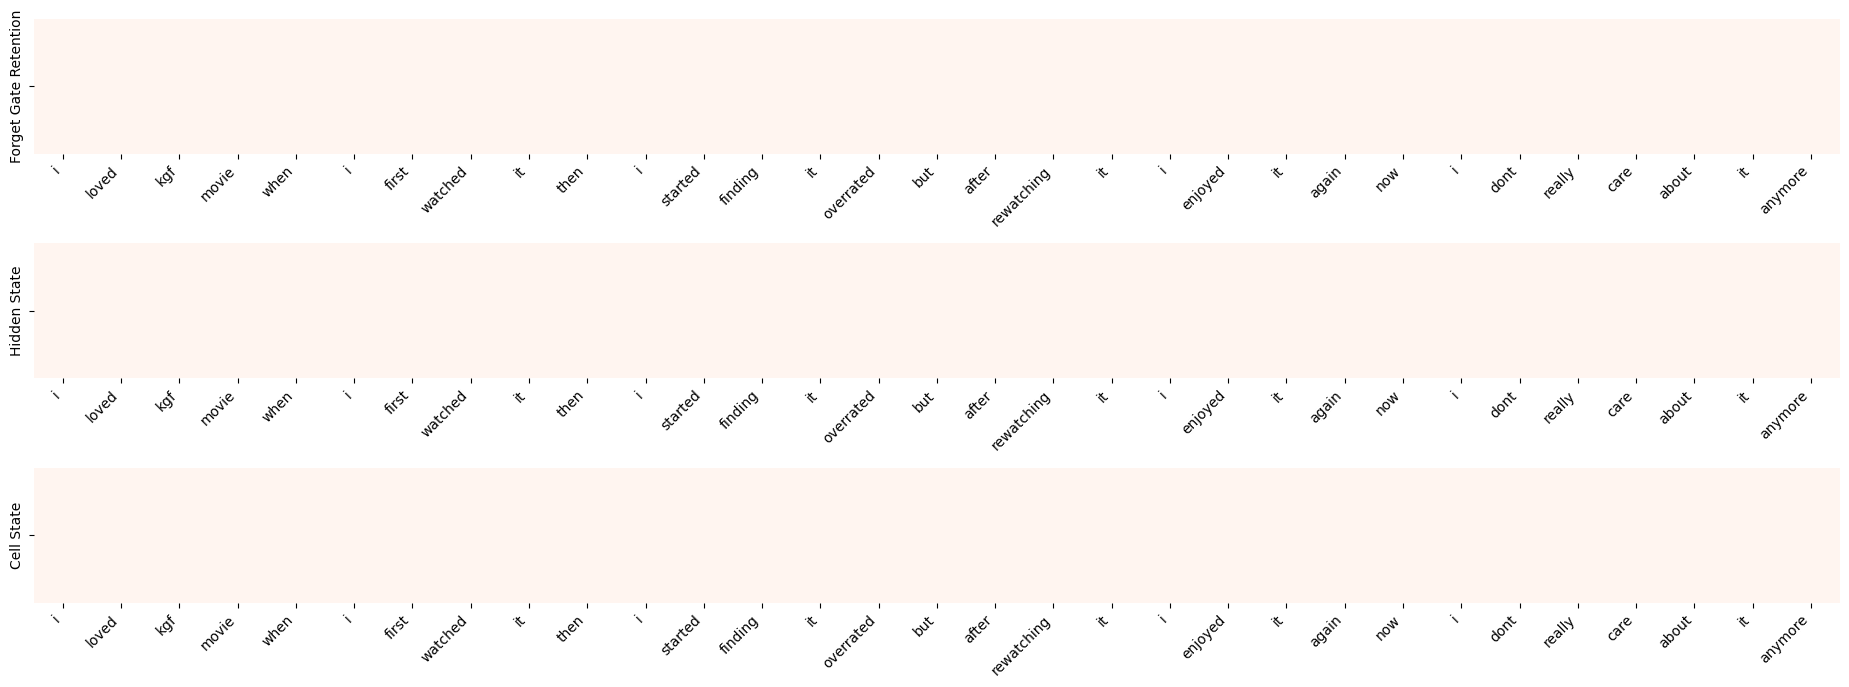

In [9]:
# Re-import necessary libraries since execution state was reset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

# Fix random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Sample sentence
sentence = "i loved kgf movie when i first watched it then i started finding it overrated but after rewatching it i enjoyed it again now i dont really care about it anymore"
words = sentence.replace(',', '').split()

# Create vocabulary
vocab = {word: i for i, word in enumerate(set(words))}
vocab_size = len(vocab)
embedding_dim = 5
hidden_size = 10

# Using PyTorch's Learnable Word Embeddings
embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# Ensure embedding layer has fixed weights for consistency
embedding_layer.weight.data.normal_(0, 0.1)

# Convert words to tensor indices
word_indices = torch.tensor([vocab[word] for word in words], dtype=torch.long)

# Custom LSTM cell to extract hidden, cell state, and forget gate values
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)
        self.reset_parameters()  # Ensuring deterministic initialization

    def reset_parameters(self):
        for param in self.parameters():
            if len(param.shape) > 1:  # Xavier for weight matrices
                nn.init.xavier_uniform_(param)
            else:  # Small values for biases
                param.data.fill_(0)

    def forward(self, x, hidden):
        hx, cx = hidden
        gates = self.x2h(x) + self.h2h(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        cy = forgetgate * cx + ingate * cellgate
        hy = outgate * torch.tanh(cy)
        return hy, cy, forgetgate, ingate, cellgate, outgate

# Instantiate LSTM
torch.manual_seed(42)
lstm_cell = CustomLSTMCell(embedding_dim, hidden_size)

# Initialize hidden state and cell state (batch size = 1)
h = torch.randn(1, hidden_size) * 0.01
c = torch.randn(1, hidden_size) * 0.01

# Store values for visualization
words_list = []
forget_retention = []
hidden_state_values = []
cell_state_values = []

# Process each word in the text
for step, word in enumerate(words):
    idx = torch.tensor([vocab[word]])
    x = embedding_layer(idx)
    h, c, f_gate, i_gate, c_gate, o_gate = lstm_cell(x, (h, c))

    forget_mean = f_gate.mean().item()
    hidden_mean = h.mean().item()
    cell_mean = c.mean().item()

    words_list.append(word)
    forget_retention.append(forget_mean)
    hidden_state_values.append(hidden_mean)
    cell_state_values.append(cell_mean)

# Define file path for combined GIF
combined_gif_path = "combined_gates_animation.gif"

# ---- Create Heatmap Animation for All Three Gates Together ----
fig, axes = plt.subplots(3, 1, figsize=(len(words_list) * 0.6, 7))
titles = ["Forget Gate Retention", "Hidden State", "Cell State"]
data = [forget_retention, hidden_state_values, cell_state_values]
cmaps = ["Reds", "Blues", "Greens"]

def init_combined():
    for ax, title in zip(axes, titles):
        ax.clear()
        sns.heatmap(np.zeros((1, len(words_list))), annot=False, cmap="Reds",
                    xticklabels=words_list, yticklabels=[title], ax=ax, cbar=False)
        ax.set_xticklabels(words_list, rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels([title], fontsize=10)
    plt.tight_layout()

def update_combined(frame):
    for ax, title, values, cmap in zip(axes, titles, data, cmaps):
        ax.clear()
        sns.heatmap([values[:frame + 1]], annot=True, fmt=".2f", cmap=cmap,
                    xticklabels=words_list[:frame + 1], yticklabels=[title], ax=ax, cbar=False)
        ax.set_xticklabels(words_list[:frame + 1], rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels([title], fontsize=12)
    plt.tight_layout()

# Create and save animation for all gates together
ani_combined = animation.FuncAnimation(fig, update_combined, frames=len(words_list), init_func=init_combined, interval=800, repeat=False)
ani_combined.save(combined_gif_path, writer='pillow', dpi=100)

# Return path to the combined GIF
combined_gif_path
